# Assignment 3 - Deep Learning
# Names: Roy Madpis, Michael Kobiavanov
## IDs: 319091526, 206814485
## Question 2

# <font color = crimson > Question 2 (30%) : </font> Predictive models for Covid-19 management.
The purpose of this assignment is to **predict the number of daily COVID-19 – related deaths in Israel** and other statistics

To complete this assignment, you will have to:
+ combine the data sources you choose into a single data frame with **daily details on the numbers of deaths** and columns like:
    + new patients
    + aggregate numbers of hospitalized patients (perhaps, distinguishing between server and light cases)
    + tests
    + people in quarantine
    + and whatever other information you might want to use (e.g. age statistics about the tested or hospitalized individuals, weekdays/holidays, etc.).

You can try being creative with the data. E.g. split tests into numbers by individual laboratories. You
are encouraged to complement the provided data with additional details (e.g. are schools or
shopping malls open? Number of incoming flights, or other data).
What, is a proper size of historical data window for prediction?

Your objectives are to **predict the future values of the numbers of the values like:**
1. Deaths
2. Positive patients
3. Hospitalized patients (total and separately for different conditions + the number of ventilated machines used).
4. Covid tests


a. For each of the cases above predict the future daily number of cases.

Demonstrate few out of sample predictions and **estimate accuracy of your algorithms on test set**. How accuracy
drops as you would look further into the future?

b. Next, assume that you are responsible for resource allocation and management of the pandemic. To do your job properly, you **need to predict daily averages of the quantities over one week** starting 3 days from the time when the data is still available.

In other words, if today is January 3, 2022, you should compute a single number representing the mean daily number of deaths over the 7 days starting from January 6.
For each of the 3 last weeks in December 2020 and for each of the quantities above report
+ the numbers you predict
+ the actual numbers observed.
+ Relative error. 

# 0. Importing packages:

In [2]:
#import imageio
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import random
import numpy as np
import pandas as pd
import math
from PIL import Image 
import requests
import time
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import json
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#################################################################
#The following function compute the number of parameters in each layer in a neural net model
#and stores the total number of parameters
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#total_params = count_parameters(model_name)


#np.set_printoptions(suppress=True)


# 1. Reading the data + little preprocessing:

In [3]:
read_api_again = True
#read_api_again = False

if read_api_again == True:
    import requests
    off_set_value = 0
    dataframe_list =[]
    work=True

    while work==True:
        try:
            url = "https://data.gov.il/api/3/action/datastore_search?resource_id=d337959a-020a-4ed3-84f7-fca182292308&limit=9999999999" + "&offset=" + str(off_set_value) 
            response = requests.get(url)
            a_json = json.loads(response.text)
            dataframe0 = pd.DataFrame(a_json["result"]["records"])
            dataframe_list.append(dataframe0)

            last_id = np.asarray(dataframe0._id)[-1]
            print("added rows with id:", off_set_value, "-", last_id)
            off_set_value = last_id #setting new off set value
        except:
            print("no more data")
            work=False
    #########################################
    print()
    print("round 2")
    print("----------------------------")
    work = True
    print(work)
    while work==True:
        try:
            url = "https://data.gov.il/api/3/action/datastore_search?resource_id=d337959a-020a-4ed3-84f7-fca182292308&limit=9999999999" + "&offset=" + str(off_set_value) 
            response = requests.get(url)
            a_json = json.loads(response.text)
            dataframe0 = pd.DataFrame(a_json["result"]["records"])
            dataframe_list.append(dataframe0)

            last_id = np.asarray(dataframe0._id)[-1]
            print("added rows with id:", off_set_value, "-", last_id)
            off_set_value = last_id #setting new off set value
        except:
            print("no more data")
            work=False

    big_df = pd.concat(dataframe_list)    

    dataframe1 = big_df.rename(columns={"test_date": "date"})
    dataframe1.set_index(dataframe1.date, inplace=True)
    dataframe1 = dataframe1.drop(labels = ["_id", "date"], axis =1)

    encoding_dict = {"שלילי":"negative", "חיובי":"positive", "אחר":"other"}
    dataframe1.corona_result = dataframe1.corona_result.map(encoding_dict)

    encoding_dict = {"זכר":"male", "נקבה":"female"}
    dataframe1.gender = dataframe1.gender.map(encoding_dict)
    dataframe1.age_60_and_above = dataframe1.age_60_and_above.fillna("unknown")

    dummies_to_join = pd.get_dummies(dataframe1[["corona_result", "gender", "age_60_and_above", "test_indication"]])

    dataframe_new = dataframe1.drop(labels = ["corona_result", "gender", "age_60_and_above", "test_indication"], axis = 1)
    dataframe_new = dataframe_new.apply(pd.to_numeric) 
    dataframe1_groupby_table = dataframe_new.groupby(by = "date").sum()
    dataframe1_groupby_table["number_of_tests"] = dataframe_new.groupby(by = "date").size()

    dummies_to_join = pd.get_dummies(dataframe1[["corona_result", "gender", "age_60_and_above", "test_indication"]])
    dummies_to_join_group = dummies_to_join.groupby(by = "date").sum()

    Details_tested_individuals_groupby_table = pd.merge(dataframe1_groupby_table, dummies_to_join_group, left_index=True, right_index=True)
    Details_tested_individuals_groupby_table.to_csv("Details_tested_individuals_groupby_table_roy")
    #Details_tested_individuals_groupby_table.to_csv("Details_tested_individuals_groupby_table_roy.csv")

added rows with id: 0 - 500000
added rows with id: 500000 - 1000000
added rows with id: 1000000 - 1500000
added rows with id: 1500000 - 2000000
added rows with id: 2000000 - 2500000
added rows with id: 2500000 - 3000000
added rows with id: 3000000 - 3500000
added rows with id: 3500000 - 4000000
added rows with id: 4000000 - 4500000
added rows with id: 4500000 - 5000000
added rows with id: 5000000 - 5500000
added rows with id: 5500000 - 6000000
added rows with id: 6000000 - 6500000
added rows with id: 6500000 - 7000000
added rows with id: 7000000 - 7500000
added rows with id: 7500000 - 8000000
added rows with id: 8000000 - 8284155
no more data

round 2
----------------------------
True
no more data


In [6]:
#Daily number of isolated citizens by reason. 
#daily_isolated_citizens = pd.read_csv("corona_isolation_per_day_ver_00107.csv")

url = "https://data.gov.il/api/3/action/datastore_search?resource_id=9eedd26c-019b-433a-b28b-efcc98de378d&limit=99999999"
response = requests.get(url)
a_json = json.loads(response.text)
#dataframe1 = pd.DataFrame.from_dict(a_json["result"]["records"], orient="index")
daily_isolated_citizens = pd.DataFrame(a_json["result"]["records"])
daily_isolated_citizens = daily_isolated_citizens.drop(labels=["_id"], axis = 1)
######################Details of the tested individuals + test outcomes. 
# Details_tested_individuals = pd.read_csv("corona_tested_individuals_ver_00210.csv")
# Details_tested_individuals = Details_tested_individuals.rename(columns={Details_tested_individuals.columns[0]: "date"})

# encoding_dict = {"שלילי":"negative", "חיובי":"positive", "אחר":"other"}
# Details_tested_individuals.corona_result = Details_tested_individuals.corona_result.map(encoding_dict)

# encoding_dict = {"זכר":"male", "נקבה":"female"}
# Details_tested_individuals.gender = Details_tested_individuals.gender.map(encoding_dict)
# Details_tested_individuals.age_60_and_above = Details_tested_individuals.age_60_and_above.fillna("unknown")

# dummies_to_join = pd.get_dummies(Details_tested_individuals[["corona_result", "gender", "age_60_and_above"]])
# Details_tested_individuals = pd.merge(Details_tested_individuals, dummies_to_join, left_index=True, right_index=True)

# Details_tested_individuals_groupby_table = Details_tested_individuals.groupby(by = "date").sum()
# ### adding the amount of test in each day
# Details_tested_individuals_groupby_table["number_of_tests"] = Details_tested_individuals.groupby(by = "date").size()

#Details_tested_individuals_groupby_table = pd.read_csv("Details_tested_individuals_groupby_table_roy.csv")
Details_tested_individuals_groupby_table = pd.read_csv("Details_tested_individuals_groupby_table_roy")

#########################################################################################################
#Daily hospitalization reports
#Daily_hospitalization = pd.read_excel("corona_hospitalization_ver_00434.xlsx")
url = "https://data.gov.il/api/3/action/datastore_search?resource_id=e4bf0ab8-ec88-4f9b-8669-f2cc78273edd&limit=99999999"
response = requests.get(url)
a_json = json.loads(response.text)
#dataframe1 = pd.DataFrame.from_dict(a_json["result"]["records"], orient="index")
Daily_hospitalization = pd.DataFrame(a_json["result"]["records"])
Daily_hospitalization = Daily_hospitalization.drop(labels=["_id"], axis=1)

Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[0]: "date"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[1]: "hospitalized"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[2]: "percent_woman_hospitalized"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[3]: "average_age_hospitalized"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[4]: "sd_age_hospitalized"})

Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[5]: "ventilated"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[6]: "percent_woman_ventilated"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[7]: "average_age_ventilated"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[8]: "sd_age_ventilated"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[9]: "percent_unvaccined_ventilated"})

Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[10]: "light_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[11]: "percent_woman_light_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[12]: "percent_unvaccined_light_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[13]: "average_age_light_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[14]: "sd_age_light_sick"})

Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[15]: "medium_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[16]: "percent_woman_medium_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[17]: "percent_unvaccined_medium_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[18]: "average_age_medium_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[19]: "sd_age_medium_sick"})

Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[20]: "hard_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[21]: "percent_woman_hard_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[22]: "percent_unvaccined_hard_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[23]: "average_age_hard_sick"})
Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[24]: "sd_age_hard_sick"})

Daily_hospitalization = Daily_hospitalization.rename(columns={Daily_hospitalization.columns[25]: "total_cumulated_hard_sick"})

Daily_hospitalization['date'] = pd.to_datetime(Daily_hospitalization['date']) 
Daily_hospitalization['date'] = Daily_hospitalization['date'].dt.strftime("%Y-%m-%d")

#############################################################################################
#Laboratory tests - didn't use as there is less data (in date col)
# Laboratory_tests = pd.read_csv("corona_lab_tests_2021-12-29.csv")

# Laboratory_tests = Laboratory_tests.rename(columns={Laboratory_tests.columns[0]: "date"})
# encoding_dict = {"שלילי אנטיגן":"negative_antigen", "שלילי":"negative",  "לא בוצע/פסול 999":"problematic_test",
#                  "חיובי גבולי באיגום":"marginal_positive_aigoom",  "חיובי גבולי":"marginal_positive",
#                  "חיובי באיגום":"positive_aigoom",  "חיובי":"positive", "בעבודה":"at_work",
#                  "בדיקה לא הגיעה למעבדה":"test_didnt_made_it_to_the_lab"}
# Laboratory_tests.corona_result = Laboratory_tests.corona_result.map(encoding_dict)
# encoding_dict = {"No":0, "Yes":1}
# Laboratory_tests.is_first_Test = Laboratory_tests.is_first_Test.map(encoding_dict)

# Laboratory_tests = Laboratory_tests.groupby(by = ["date", "corona_result"]).sum()

# Laboratory_tests = pd.pivot_table(Laboratory_tests, values =  ['test_for_corona_diagnosis', 'is_first_Test'],
#               index = "date", columns=["corona_result"])

# Laboratory_tests.columns = [' '.join(col).strip() for col in Laboratory_tests.columns.values]
# Laboratory_tests = Laboratory_tests.fillna(0)

#############################################################################################
WHO_data = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")
WHO_data = WHO_data[WHO_data.Country == "Israel"]
WHO_data = WHO_data.rename(columns={"Date_reported": "date"})
WHO_data = WHO_data.drop(labels = ["Country", "Country_code", "WHO_region"], axis = 1)

In [10]:
print_tables = True # False

if print_tables:
    display(daily_isolated_citizens.tail())
    print("--------------------------------------------------------------------------")
    display(Details_tested_individuals_groupby_table.tail())
    print("--------------------------------------------------------------------------")
    display(Daily_hospitalization.tail())
    print("--------------------------------------------------------------------------")
    #display(Laboratory_tests.tail())
    print("--------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------")
    display(WHO_data.tail())

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
675,2022-01-05,70850,26622,15517,5683
676,2022-01-06,68426,26823,13344,7109
677,2022-01-07,65812,26710,8775,5495
678,2022-01-08,71538,24199,7698,4650
679,2022-01-09,76654,26800,17791,7898


--------------------------------------------------------------------------


,date,cough,fever,sore_throat,shortness_of_breath,head_ache,number_of_tests,corona_result_negative,corona_result_other,corona_result_positive,gender_female,gender_male,age_60_and_above_NULL,age_60_and_above_No,age_60_and_above_Yes,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other
665,2022-01-05,369,198,174,14,236,25922,20917.0,1074.0,3931.0,12608.0,11197.0,1055.0,21344.0,3523.0,67.0,591.0,25264.0
666,2022-01-06,357,228,141,15,198,24210,18889.0,1114.0,4207.0,11916.0,10488.0,1025.0,19727.0,3458.0,49.0,580.0,23581.0
667,2022-01-07,376,210,127,10,219,17802,13608.0,834.0,3360.0,8825.0,7602.0,566.0,14280.0,2956.0,83.0,665.0,17054.0
668,2022-01-08,350,197,127,7,186,17981,13839.0,470.0,3672.0,8961.0,7777.0,552.0,14322.0,3107.0,44.0,633.0,17304.0
669,2022-01-09,481,316,207,19,284,32468,23107.0,1177.0,8184.0,15373.0,13610.0,1114.0,25918.0,5436.0,80.0,931.0,31457.0


--------------------------------------------------------------------------


,date,hospitalized,percent_woman_hospitalized,average_age_hospitalized,sd_age_hospitalized,ventilated,percent_woman_ventilated,average_age_ventilated,sd_age_ventilated,percent_unvaccined_ventilated,...,percent_woman_medium_sick,percent_unvaccined_medium_sick,average_age_medium_sick,sd_age_medium_sick,hard_sick,percent_woman_hard_sick,percent_unvaccined_hard_sick,average_age_hard_sick,sd_age_hard_sick,total_cumulated_hard_sick
665,2022-01-05,478,51.9,59.4,24.4,37.0,40.5,51.9,13.1,89.2,...,60.6,42.4,67.0,24.1,128.0,39.8,65.6,63.0,17.2,23228.0
666,2022-01-06,510,52.0,59.6,24.5,39.0,38.5,50.9,13.0,92.3,...,51.4,51.4,68.6,22.0,132.0,40.2,58.3,63.5,18.3,23252.0
667,2022-01-07,524,49.8,59.9,24.5,43.0,37.2,53.0,15.0,88.4,...,48.7,30.8,66.6,20.8,148.0,41.2,58.8,66.2,16.7,23282.0
668,2022-01-08,597,51.9,60.6,24.4,46.0,37.0,55.0,16.7,87.0,...,48.9,34.0,65.9,23.3,160.0,40.6,53.1,67.5,16.2,23309.0
669,2022-01-09,725,53.2,61.5,24.6,49.0,36.7,53.7,18.4,85.7,...,47.4,39.5,68.0,20.2,191.0,44.5,47.1,68.8,17.5,23355.0


--------------------------------------------------------------------------
--------------------------------------------------------------------------
--------------------------------------------------------------------------


,date,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
76215,2022-01-07,17082,1454627,1,8265
76216,2022-01-08,18995,1473622,2,8267
76217,2022-01-09,17723,1491345,1,8268
76218,2022-01-10,21514,1512859,1,8269
76219,2022-01-11,37887,1550746,2,8271


# 3. Creating the data for the model:

In [11]:
df = WHO_data.copy()
df = df.merge(daily_isolated_citizens,on = "date")
df = df.merge(Details_tested_individuals_groupby_table,on = "date")
df = df.merge(Daily_hospitalization, on = "date")

# need to change the type of column medium_sick to float (instead of object)
value_to_replae = 0
df["medium_sick"] = df["medium_sick"].replace(to_replace = "<15", value = value_to_replae) #7.5 is the mean value between 0 and 15
df["hard_sick"] = df["hard_sick"].replace(to_replace = "<15", value = value_to_replae) #7.5 is the mean value between 0 and 15
df["total_cumulated_hard_sick"] = df["total_cumulated_hard_sick"].replace(to_replace = "<15", value = value_to_replae) #7.5 is the mean value between 0 and 15
df["ventilated"] = df["ventilated"].replace(to_replace = "<15", value = value_to_replae) #7.5 is the mean value between 0 and 15

df["new_from_abroad"] = pd.to_numeric(df["new_from_abroad"], errors='coerce', downcast="float")
df["new_contact_with_confirmed"] = pd.to_numeric(df["new_contact_with_confirmed"], errors='coerce', downcast="float")
df["isolated_today_contact_with_confirmed"] = pd.to_numeric(df["isolated_today_contact_with_confirmed"], errors='coerce', downcast="float")
df["isolated_today_abroad"] = pd.to_numeric(df["isolated_today_abroad"], errors='coerce', downcast="float")
df["ventilated"] = pd.to_numeric(df["ventilated"], errors='coerce', downcast="float")
df["medium_sick"] = pd.to_numeric(df["medium_sick"], errors='coerce', downcast="float")
df["percent_woman_medium_sick"] = pd.to_numeric(df["percent_woman_medium_sick"], errors='coerce', downcast="float")
df["percent_unvaccined_medium_sick"] = pd.to_numeric(df["percent_unvaccined_medium_sick"], errors='coerce', downcast="float")
df["average_age_medium_sick"] = pd.to_numeric(df["average_age_medium_sick"], errors='coerce', downcast="float")
df["ventilsd_age_medium_sickated"] = pd.to_numeric(df["sd_age_medium_sick"], errors='coerce', downcast="float")
df["hard_sick"] = pd.to_numeric(df["hard_sick"], errors='coerce', downcast="float")
df["sd_age_medium_sick"] = pd.to_numeric(df["sd_age_medium_sick"], errors='coerce', downcast="float")
df["total_cumulated_hard_sick"] = pd.to_numeric(df["total_cumulated_hard_sick"], errors='coerce', downcast="float")

df.new_from_abroad = df.new_from_abroad.fillna(0)
df.new_contact_with_confirmed = df.new_contact_with_confirmed.fillna(0)
df.percent_unvaccined_medium_sick = df.percent_unvaccined_medium_sick.fillna(0)
df.average_age_medium_sick = df.average_age_medium_sick.fillna(0)
df.sd_age_medium_sick = df.sd_age_medium_sick.fillna(0)
df.ventilsd_age_medium_sickated = df.ventilsd_age_medium_sickated.fillna(0)


df = df.rename(columns={"New_cases": "Daily_new_cases"})
df = df.rename(columns={"New_deaths": "Daily_death_cases"})

df = df.fillna(0)
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d')

start_date = np.asarray(df.date.dt.strftime("%Y-%m-%d"))[0]
end_date = np.asarray(df.date.dt.strftime("%Y-%m-%d"))[-1]
print("Data has", df.shape[0], "rows and", df.shape[1], "columns")
print("Data starts in", start_date, "and ends in", end_date)

df.head()

Data has 670 rows and 52 columns
Data starts in 2020-03-11 and ends in 2022-01-09


,date,Daily_new_cases,Cumulative_cases,Daily_death_cases,Cumulative_deaths,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,cough,...,percent_unvaccined_medium_sick,average_age_medium_sick,sd_age_medium_sick,hard_sick,percent_woman_hard_sick,percent_unvaccined_hard_sick,average_age_hard_sick,sd_age_hard_sick,total_cumulated_hard_sick,ventilsd_age_medium_sickated
0,2020-03-11,33,85,0,0,5565.0,31175.0,2073.0,4426.0,121,...,0.0,0.000000,0.000000,0.0,33.3,100.0,67.3,16.2,0.0,0.000000
1,2020-03-12,19,104,0,0,7689.0,34108.0,2325.0,4495.0,248,...,0.0,0.000000,0.000000,0.0,33.3,100.0,67.3,16.2,0.0,0.000000
2,2020-03-13,22,126,0,0,8981.0,35569.0,1498.0,3595.0,267,...,100.0,68.000000,16.700001,0.0,33.3,100.0,67.3,16.2,0.0,16.700001
3,2020-03-14,35,161,0,0,9969.0,35237.0,1442.0,2364.0,167,...,100.0,68.000000,16.700001,0.0,20.0,100.0,76.8,10.3,0.0,16.700001
4,2020-03-15,29,190,0,0,13327.0,35973.0,5196.0,3923.0,138,...,100.0,61.299999,17.500000,0.0,37.5,100.0,79.0,9.1,0.0,17.500000


In [12]:
#senity check:
df[df.isna().any(axis=1)]

,date,Daily_new_cases,Cumulative_cases,Daily_death_cases,Cumulative_deaths,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,cough,...,percent_unvaccined_medium_sick,average_age_medium_sick,sd_age_medium_sick,hard_sick,percent_woman_hard_sick,percent_unvaccined_hard_sick,average_age_hard_sick,sd_age_hard_sick,total_cumulated_hard_sick,ventilsd_age_medium_sickated


In [13]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670 entries, 0 to 669
Data columns (total 52 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   date                                    670 non-null    datetime64[ns]
 1   Daily_new_cases                         670 non-null    int64         
 2   Cumulative_cases                        670 non-null    int64         
 3   Daily_death_cases                       670 non-null    int64         
 4   Cumulative_deaths                       670 non-null    int64         
 5   isolated_today_contact_with_confirmed   670 non-null    float32       
 6   isolated_today_abroad                   670 non-null    float32       
 7   new_contact_with_confirmed              670 non-null    float32       
 8   new_from_abroad                         670 non-null    float32       
 9   cough                                   670 non-null  

# 4. Defining the modeling data -  <font color = blue > Class TimeSeriesDataSet </font>  

+ **df** = The dataframe that has a column of dates and other columns
+ **history_samples** = The number of samples (=rows n the given `df`) that will be converted into one new row in the modeling_df. In other words this variable controls the size of the history we wish to use for prediction. lets say you insert history_samples = 4 and the dates are days: this will create a new dataframe were each row contains data regarding 4 ordered days. 

+ **horizon_samples** = "How far" We wish to predict / for how long (/how deep) in the future we wish to predict.
    This variable controls the **labels**, it answers the question: given data on #`history_samples` minutes/hours/days/months/years... (lets say 4 days) then what will be the value of a given column in #'horizon_samples' minutes/hours/days/months/years... (lets say horizon_samples = 3 - then what will the the predicted column value in 1-3 days)

+ **label_to_predict** = The name column in **`df`** that we wish to predict its future values

+ **name_of_date_col** = The name of the date column in `df`

In [15]:
class TimeSeriesDataSet(torch.utils.data.Dataset):
    """Loads and provides access to MNIST Dataset"""
    
    def __init__(self, df, history_samples, horizon_samples, label_to_predict, name_of_date_col = "date"):
        import pandas as pd, os, torch, numpy as np
        super(TimeSeriesDataSet).__init__() # call parent class constructor. 
        
        self.df = df
        self.history_samples = history_samples
        self.horizon_samples = horizon_samples
        self.label_to_predict = label_to_predict
        
        #if the date column contains data on days of the week:
        self.df['weekday'] = self.df[name_of_date_col].apply(lambda x: x.weekday())

        self.df = self.df.reset_index(drop=True).set_index(name_of_date_col)        
        self.df = pd.get_dummies(self.df, columns=['weekday'], dtype=np.float32)
        
        self.number_of_channels = self.df.shape[1] # number of columns. 

    def __len__(self):
        return len(self.df) - self.history_samples - self.horizon_samples + 1

    def __getitem__(self, idx):
        import torch
        if idx >= self.__len__():
            raise  IndexError(f'Index out of range: {idx} out of {self.__len__()}')
        x = torch.FloatTensor(self.df.iloc[idx:idx+ self.history_samples].values)
        y = torch.FloatTensor(self.df.iloc[idx+ self.history_samples : idx+self.history_samples + self.horizon_samples][self.label_to_predict].values)
        return (x, y) # number of samples, number of channels
    
#this function enables getting a table of X-point and a table of Y labels for a given index
def get_x_y_table(TimeSeriesDataSet_object, idx):
    import torch
    if idx >= len(TimeSeriesDataSet_object):
        raise  IndexError(f'Index out of range: {idx} out of {len(TimeSeriesDataSet_object)}')
    x = TimeSeriesDataSet_object.df.iloc[idx:idx+ TimeSeriesDataSet_object.history_samples]
    y = TimeSeriesDataSet_object.df.iloc[idx+ TimeSeriesDataSet_object.history_samples : idx+TimeSeriesDataSet_object.history_samples + TimeSeriesDataSet_object.horizon_samples][TimeSeriesDataSet_object.label_to_predict]
    return (x, y) # number of samples, number of channels

In [16]:
#all_data = TimeSeriesDataSet object
#train_portion = the portion of training points out of all the avialable data
def train_test_split_roy(all_data, train_portion=0.9):
    X_train_table = []
    Y_train_table = []
    for i in list(range(int(len(all_data)*train_portion))):
        x_table, y_table = get_x_y_table(all_data, i)
        X_train_table.append(x_table)
        Y_train_table.append(y_table)

    X_test_table = []
    Y_test_table = []
    for i in list(range(int(len(all_data)*train_portion)+all_data.history_samples+all_data.horizon_samples, len(all_data))):
        x_table, y_table = get_x_y_table(all_data, i)
        X_test_table.append(x_table)
        Y_test_table.append(y_table)
    
    X_train_table = pd.concat(X_train_table)
    Y_train_table = pd.concat(Y_train_table)
    X_test_table = pd.concat(X_test_table)
    Y_test_table = pd.concat(Y_test_table)
    
    return X_train_table, Y_train_table, X_test_table, Y_test_table

In [17]:
history_samples = 7
horizon_samples = 3 #for how long (/how deep) in the future we wish to predict = 7 days

# label_to_predict = ["Daily_new_cases", "Daily_death_cases", "hospitalized",
#                     "light_sick", "medium_sick", "medium_sick", "hard_sick", "ventilated"]

label_to_predict = "Daily_death_cases" #column to predict

label_to_predict = "Daily_new_cases"

########################################################################################
all_data = TimeSeriesDataSet(df=df,
                             history_samples = history_samples,
                             horizon_samples = horizon_samples,
                             label_to_predict = label_to_predict,
                             name_of_date_col = "date")

time_interval = "days"
print("Using data of |", history_samples, "| past", time_interval, "in order to predict the value of: |",
      label_to_predict, "| for the following |", horizon_samples, "| future", time_interval)

Using data of | 7 | past days in order to predict the value of: | Daily_new_cases | for the following | 3 | future days


In [18]:
all_data[0][1].shape

torch.Size([3])

In [19]:
all_data[0][0].shape

torch.Size([7, 58])

# 5.  Splitting data into trainst and testset:

In [29]:
train_portion = 0.9

train_set = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*train_portion))))
test_set = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*train_portion)+all_data.history_samples+all_data.horizon_samples, len(all_data))))

print(f'Data set has: {len(all_data)} rows | history size: {all_data.history_samples} | Prediction window size: {all_data.horizon_samples} ')
print(f"Train set size: {len(train_set)}: from {train_set.indices[0]} to: {train_set.indices[-1]}")
print(f"Test set size: {len(test_set)}: from {test_set.indices[0]} to: {test_set.indices[-1]}")
print(f"sample size: x: {train_set[0][0].shape}, y: {train_set[0][1].shape}")
##########################################
#getting an x_train and y_train tables
# train_loader_all_data_together = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), drop_last=False)
# for x, y in train_loader_all_data_together:
#             x_train, y_train = x,y
        
# test_loader_all_data_together = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), drop_last=False)
# for x, y in test_loader_all_data_together:
#             x_test, y_test = x,y

Data set has: 661 rows | history size: 7 | Prediction window size: 3 
Train set size: 594: from 0 to: 593
Test set size: 57: from 604 to: 660
sample size: x: torch.Size([7, 58]), y: torch.Size([3])


In [30]:
# print("x train shape before:", x_train.shape)
# x_train = x_train.reshape(x_train.shape[0],-1)
# print("x train shape after reshape:", x_train.shape)
# print()
# print("x test shape before:", x_test.shape)
# x_test = x_test.reshape(x_test.shape[0],-1)
# print("x test shape after reshape:", x_test.shape)


# 6. Scaling the data:

In [31]:
#train_set[0][0]
train_set[0][0].shape

torch.Size([7, 58])

In [32]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
# train scaler on the train set: 0 to len(train_set) + history_samples + horizon_samples
scaler.fit(all_data.df.iloc[:len(train_set)+all_data.history_samples+all_data.horizon_samples]) #fitting the scaler
#only according to the train data points
all_data.df.iloc[:] = scaler.transform(all_data.df) #now using the scaler that was fitted oonly to the train points -
#to the whole data! (including the test points that now will be scaled according to the train-scaler)
    
### scaling the y_labels:
scaler_y = StandardScaler()
scaler_y.fit(np.asarray(all_data.df[label_to_predict][:len(train_set)+all_data.history_samples+all_data.horizon_samples]).reshape(-1,1))
all_data.df.loc[:,label_to_predict] = scaler_y.transform(np.asarray(all_data.df[label_to_predict].iloc[:]).reshape(-1,1))

In [33]:
# scaler.fit(all_data.df.drop(labels=[label_to_predict], axis = 1).iloc[:len(train_set)+all_data.history_samples+all_data.horizon_samples]) #fitting the scaler
# #only according to the train data points
# all_data.df.drop(labels=[label_to_predict], axis = 1).iloc[:] = scaler.transform(all_data.df.drop(labels=[label_to_predict], axis = 1).iloc[:]) #now using the scaler that was fitted oonly to the train points -
# #to the whole data! (including the test points that now will be scaled according to the train-scaler)

# ### scaling the y_labels:

In [34]:
scaler_y = StandardScaler()
scaler_y.fit(np.asarray(all_data.df[label_to_predict][:len(train_set)+all_data.history_samples+all_data.horizon_samples]).reshape(-1,1))
#all_data.df.loc[:,label_to_predict] = scaler_y.transform(np.asarray(all_data.df[label_to_predict].iloc[:]).reshape(-1,1))

StandardScaler()

In [35]:
#check the scaling
all_data.df[label_to_predict][:len(train_set)+all_data.history_samples+all_data.horizon_samples].mean()
all_data.df[label_to_predict].mean()
#all_data.df[label_to_predict].std()

0.008226604922682896

In [36]:
print("column means:")
print(all_data.df.mean(axis=0))
print("----------------------------------------------")
print("columns sd:")
print(all_data.df.std())

column means:
Daily_new_cases                           0.008227
Cumulative_cases                          0.194954
Daily_death_cases                        -0.081401
Cumulative_deaths                         0.154356
isolated_today_contact_with_confirmed    -0.022584
isolated_today_abroad                     0.094096
new_contact_with_confirmed               -0.002544
new_from_abroad                           0.164614
cough                                    -0.095052
fever                                    -0.104006
sore_throat                              -0.090974
shortness_of_breath                      -0.105965
head_ache                                -0.093191
number_of_tests                          -0.056805
corona_result_negative                   -0.064000
corona_result_other                       0.078539
corona_result_positive                   -0.030523
gender_female                            -0.055266
gender_male                              -0.060883
age_60_and_above_

In [37]:
all_data.df.shape

(670, 58)

# 7. Spliting train data into x_train and y_train + spliting test data into x_test and y_test:

In [38]:
example_X_train = train_set[0][0] #this is one of the X-training points
print(example_X_train.shape)
print("Number of rows from the original data that are used in **one** train point =", example_X_train.shape[0])
print("Number of features in each train point =", example_X_train.shape[1])

input_dim = example_X_train.shape[1]
print(input_dim)
###see that this yeilds the same
input_dim = all_data.number_of_channels
print(input_dim)

torch.Size([7, 58])
Number of rows from the original data that are used in **one** train point = 7
Number of features in each train point = 58
58
58


In [39]:
#example_X_train

In [40]:
example_y_train = train_set[0][1]  #this is one of the y-training points (the true labels)
print(example_y_train.shape)
print("Number of labels in each y-train point =", example_y_train.shape[0])

output_dim = example_y_train.shape[0]
print(output_dim)
###see that this yeilds the same
output_dim = all_data.horizon_samples
print(output_dim)

torch.Size([3])
Number of labels in each y-train point = 3
3
3


In [41]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=3, shuffle=True, drop_last=False)    
# #x_train_t, y_train_t = next(iter(train_loader))
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=3, shuffle=True, drop_last=False)    
# #x_test_t, y_test_t = next(iter(test_loader))

# 8. Defining the 1st model -   <font color = purple > LSTM Net models class: </font> 

### This class enables defining a neural net model using LSTM Model.

The class needs to get as input:

**LSTM layer parameters:**
1. **input_dim** = The **number of features** in **every X train sample**.
<font color = forestgreen >  **Note:** </font>  There is an attribute of the data that is loaded using the `TimeSeriesDataSet` class which is called: **`number_of_channels`** That is equal to the number of features the data has. (`all_data.number_of_channels`)

2. **hidden_dim** = The **number of features** in the **hidden state - $h$**.
This defines the vector output by LSTM (and size of the input to the next layer). This also defines the size of the memory vector $c$.

3. **num_LSTM_layers** = The number of stacked LSTM layers

4. **output_dim** =  The dimension of the output layer  - This supposed to be the number of features we are predicting, which is equal to the size to the y vector. 
<font color = forestgreen >  **Note:** </font>  There is an attribute of the data that is loaded using the `TimeSeriesDataSet` class which is called: **`horizon_samples`** That is equal to the number of features we are predicting (`all_data.horizon_samples`)

5. **fully_connected_layers** = The dimensions for the fully connected layers to put after the LSTM layer

6. **drop_out_for_fully_connected** = If you wish to include drop out in each hidden layer in the fully connected layers, then pass a `float between 0 to 1`. **default** = *0*

7. **batch_norm_for_fully_connected** = If you wish to add a batch normalization layer in the fully connected layer then pass `True`. **default** = *False*

############################### more LSTM parameters:

`batch_first` is one of the LSTM layer parameters: Boolean (**False** by default). Defines the order of dimensions in $X$. 
    - False: (sequence, batch, feature)
    - True: (batch, sequence, feature)
 
`dropout` - If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0 


In [42]:
class LSTM_model_regression(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_LSTM_layers, output_dim,
                 fully_connected_layers=[512, 256], drop_out_for_fully_connected = 0, batch_norm_for_fully_connected = False):
        super(LSTM_model_regression, self).__init__()
        self.input_dim = input_dim    # number of features in the input. Typically 1. 
        self.hidden_dim = hidden_dim  # number of features in the hidden state and memory channel. 
        self.num_LSTM_layers=num_LSTM_layers      # number of stacked LSTM layers. 

        # Define the LSTM layer
        self.lstm = torch.nn.LSTM(
                input_size=self.input_dim, 
                hidden_size = self.hidden_dim, 
                num_layers = self.num_LSTM_layers,
                batch_first=True)

        # Define the dense layers. 
        layers = [self.hidden_dim] + fully_connected_layers + [output_dim]
        
        layers_list = []
        for Layer_i in range(1, len(layers)): #1,2,3,... according to the number of layers given
            layers_list.append(torch.nn.Linear(layers[Layer_i-1], layers[Layer_i]) )

            if Layer_i < len(layers)-1: #if the layer i is not the last layer - add a ReLU 
                layers_list.append( torch.nn.ReLU() )
                if drop_out_for_fully_connected != 0 :
                    layers_list.append(torch.nn.Dropout(drop_out_for_fully_connected))
                if batch_norm_for_fully_connected:
                    layers_list.append(torch.nn.BatchNorm1d(layers[Layer_i]))

        
        self.layers_stack = torch.nn.Sequential(*layers_list) #this will enable getting params that can be trained
        self.layers = layers_list 
        
    def forward(self, x):
        if x.ndim==2:
            x = x.unsqueeze(0) # prepend with dummy batch dimension. used to process a single entry of size [history, 1]
        batch_size = x.shape[0] # first dimension of the input is the number of batches. 
        device = next(self.lstm.parameters()).device # get device on which the model is loaded. 

        # initialize the hidden state (with 0s): num_layers, minibatch_size, hidden_dim
        #hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        #cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
      
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden and self.cell:  (num_layers, batch_size, hidden_dim).
        #lstm_out, (self.hidden, self.cell) = self.lstm(x, (hidden, cell))
        lstm_out, (hidden, cell) = self.lstm(x)
        # Only take the output from the final timetep or pass on the entire lstm_out to the next layer 
        #print(lstm_out.shape)
        x = lstm_out[:,-1,:].view(batch_size, -1) # result size; batch_size x hidden_dim
        
        #####x = x.view(-1,self.input_layer) # flatten image input. This code will work for input as vector or image. will also work for batches. 

        x = self.layers_stack(x)
        #print(x.shape)
        return x

In [43]:
input_dim = all_data.number_of_channels
hidden_dim = 20
num_LSTM_layers = 1
fully_connected_layers=[150, 50]
output_dim = all_data.horizon_samples

lstm_model = LSTM_model_regression(input_dim = input_dim,
                                   hidden_dim = hidden_dim,
                                   num_LSTM_layers = num_LSTM_layers,
                                   output_dim = output_dim,
                                   fully_connected_layers = fully_connected_layers,
                                   drop_out_for_fully_connected = 0,
                                   batch_norm_for_fully_connected = True)
lstm_model

LSTM_model_regression(
  (lstm): LSTM(58, 20, batch_first=True)
  (layers_stack): Sequential(
    (0): Linear(in_features=20, out_features=150, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=150, out_features=50, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [ ]:
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, drop_last=False)    
#x_train_t, y_train_t = next(iter(train_loader))

In [ ]:
#lstm_model(x_train_t)

#   <font color = blue > 8. Defining Model MSE & R^2 function </font> 
This function will enable calculating a **regression model** performance - get its MSE and R^2. It can be used on the training set, validation set and the test set.

The function gets as input:
1. **model** - The model object we wish to measure its MSE and R^2
2. **data_loader** - data_loader containing the x-data and the y-data (the labels)


In [44]:
#this function use bathces it assumes the dataloader loads the data in the dataset in multiple batches!
def model_mse_r2(model, data_loader):  
    from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
    
    device = next(model.parameters()).device # get device on which the model is loaded. 
    model.eval() # must set model to evaluation mode to disable dropout!
    with torch.no_grad():
        current_mse, samples_counts, r_2_data = 0, 0, 0
        for X, y in data_loader: 
            X, y = X.to(device=device), y.to(device=device)
            y_pred = model(X)
            current_mse += torch.nn.MSELoss()(y_pred, y)*len(y)
            r_2_data+= r2_score(y.detach().numpy(), model(X).detach().numpy())
            samples_counts += len(y)
            
        return current_mse/samples_counts, r_2_data/samples_counts

In [45]:
#This function doesn't use bathces it assumes the dataloader loads all the data in the dataset in 1 batch!
def model_mse_r2_one_shot(model, data_loader): 
    from sklearn.metrics import mean_squared_error, r2_score
    device = next(model.parameters()).device # get device on which the model is loaded. 
    model.eval() # must set model to evaluation mode to disable dropout!
    with torch.no_grad():
        #number_of_matches = 0
        for x, y in data_loader:
            x_data, y_data = x.to(device=device), y.to(device=device)
            mse_data = mean_squared_error(y_data.cpu(), model(x_data).cpu().detach())
            r_2_data = r2_score(y_data.cpu().detach().numpy(), model(x_data).cpu().detach().numpy())
        return mse_data, r_2_data

In [46]:
#test_loader_all_data_together =  torch.utils.data.DataLoader(test_set, batch_size=len(test_set), drop_last=False)  
#model_mse_r2_one_shot(lstm_model_new, test_loader_all_data_together)

# <font color = blue > 9. Define Training function For MLP - Multilayer perceptron</font>  
### The function gets as input:

1. neural net model, untrained
2. x_train matrix (normalized and tensor type)
3. y_train vector (normalized and tensor type)
4. **Optimizer** - (The optimizer responsible to take the parameters (weights) that needs to be optimized and updates them according to the derivative
5. **Criterion** - the loss function

------------------------------- optional : -------------------------------

6. **optional: x_validation_normalize_t** (x validation matrix - normalized and of type torch.tensor)
7. **optional: y_validation_t** (y validation vector - normalized and of type torch.tensor)

If *x_validation_normalize_t* is not provided, everything will be fine, you just won't get the validation accuracy score along the way.

--------------------------------------------------------------
8. n_epochs = the number of epochs, default = 50
9. batch_size = the size of each batch in the training loop, default = 500
10. device - use GPU  or CPU?, default = cpu

In [47]:
def train_MLP_net_images(model, train_set, criterion, optimizer,
                         test_set = None,
                         n_epochs=50, batch_size=500, device="cpu", random_state = None):
    
    if random_state is not None:
        torch.manual_seed(random_state)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)    
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=False)    
    
    train_loader_all_data_together = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), drop_last=False)
    test_loader_all_data_together =  torch.utils.data.DataLoader(test_set, batch_size=len(test_set), drop_last=False)  
    ##########################################
        
    #checking if given validation set arguements
    if test_loader is None:
        validation_set_checker = False
    else:
        validation_set_checker = True
    ##########################################
    training_time_epochs = []
    progress_log = []
    model.to(device)
    
    for epoch in range(n_epochs):
        model.train() # set model into train mode. 
        current_loss = 0
        # prepare data for the current epoch (iterate over random indeces)        
        
        training_time_batches = []
        for train_data, train_data_labels in train_loader: #for each row of indexes
            train_data, train_data_labels = train_data.to(device=device), train_data_labels.to(device=device)
            
            optimizer.zero_grad() # clear gradients of all model parameters.
            
            start_train_time = time.time() #train time calculation
            output = model(train_data) # forward pass: compute model predictions
            batch_train_time = time.time() - start_train_time
            training_time_batches.append(batch_train_time)
            
            loss = criterion(output, train_data_labels) # calculate the current loss
            loss.backward() # backward pass: compute gradient of the loss for all model parameters. 
            optimizer.step() # use gradients to update the model parameters 

            current_loss += loss.item() * len(train_data) # weight loss by the size of the batch.
            

        training_time_epochs.append(np.mean(training_time_batches))
        # evaluate performance of the batch
        with torch.no_grad(): # disable autograd
            train_mse, train_r2 = model_mse_r2_one_shot(model, train_loader_all_data_together)
            if validation_set_checker:
                validate_mse, validation_r2 = model_mse_r2_one_shot(model, test_loader_all_data_together)
            
            if validation_set_checker:
                if (epoch % 2 == 1 or epoch == n_epochs-1) :
                    print(f"{epoch} of {n_epochs} | Loss: {current_loss/ len(train_loader):0.4f} | Train MSE: {train_mse:0.4f} | Train R^2: {train_r2:0.4f} ||| Validate MSE: {validate_mse:0.4f} | Validation R^2: {validation_r2:0.4f}")
            else:
                print(f"{epoch} of {n_epochs} | Loss: {current_loss/ len(train_loader):0.4f} | Train MSE: {train_mse:0.4f} | Train R^2: {train_r2:0.4f} ")
                validate_mse = None

            progress_log.append({'epoch':epoch,
                                 'loss':current_loss/len(train_loader),
                                 'train epoch time': training_time_epochs[epoch],
                                 'train_MSE':train_mse, 'train_R2':train_r2, 'validate_MSE':validate_mse, 'validation_R2':validation_r2 })

    print()
    total_train_time = np.sum(training_time_epochs)
    print("Total train time = ", total_train_time," seconds")
    print("Total train time = ", np.round(total_train_time/60,3)," minutes")
    model.eval(); # set model mode to evaluation. 
    return model, progress_log

# 10. Testing MLP - Multilayer perceptron

In [ ]:
#all together:
input_dim = all_data.number_of_channels 
hidden_dim = 200
num_LSTM_layers = 2
fully_connected_layers=[300, 250, 100]
output_dim = all_data.horizon_samples

### defining the model
lstm_model = LSTM_model_regression(input_dim = input_dim,
                                   hidden_dim = hidden_dim,
                                   num_LSTM_layers = num_LSTM_layers,
                                   output_dim = output_dim,
                                   fully_connected_layers = fully_connected_layers,
                                   drop_out_for_fully_connected = 0.15,
                                   batch_norm_for_fully_connected = True).to(device=device)
#parameters for the training loop
criterion = torch.nn.MSELoss()#The loss function
optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 0.005)#The optimizer
#torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = torch.optim.SGD(lstm_model.parameters(), lr = 0.0001) 
n_epochs = 100
batch_size = 100

lstm_model_new, progress_log = train_MLP_net_images(model = lstm_model,
                                                    train_set = train_set,
                                                    criterion = criterion, optimizer = optimizer,
                                                    test_set = test_set,
                                                    n_epochs = n_epochs, batch_size = batch_size, device = device,
                                                    random_state = 1998)


# 11. Plotting MLP - Multilayer perceptron results

In [ ]:
epoch_list =[]
loss_list =[]
train_MSE_list =[]
train_R2_list =[]
validate_MSE_list =[]
validation_R2_list =[]

for epoch_log in progress_log:
    epoch_list.append(epoch_log["epoch"])
    loss_list.append(epoch_log["loss"])
    train_MSE_list.append(epoch_log["train_MSE"])
    train_R2_list.append(epoch_log["train_R2"])
    validate_MSE_list.append(epoch_log["validate_MSE"])
    validation_R2_list.append(epoch_log["validation_R2"])

fig, ax = plt.subplots(3,2, figsize=(12,12))
print("model performance regarding the variable:", label_to_predict)
ax[0][0].plot(epoch_list, loss_list)
ax[0][0].set_xlabel('epoch', fontsize=20);
ax[0][0].set_ylabel('MSE loss', fontsize=20);
ax[0][0].set_title("Train loss Vs Epochs", fontdict = {"fontsize": 20})

ax[0][1].plot(epoch_list, train_R2_list)
ax[0][1].set_xlabel('epoch', fontsize=20);
ax[0][1].set_ylabel('R^2 train', fontsize=20);
ax[0][1].set_title("Train R^2 Vs Epochs", fontdict = {"fontsize": 20})


ax[1][0].plot(epoch_list, validate_MSE_list)
ax[1][0].set_xlabel('epoch', fontsize=20);
ax[1][0].set_ylabel('validate_MSE', fontsize=20);
ax[1][0].set_title("Validation loss Vs Epochs", fontdict = {"fontsize": 20})

ax[1][1].plot(epoch_list, validation_R2_list)
ax[1][1].set_xlabel('epoch', fontsize=20);
ax[1][1].set_ylabel('R^2 validation', fontsize=20);
ax[1][1].set_title("Validation R^2 Vs Epochs", fontdict = {"fontsize": 20})


index_to_see_results_from = 0
ax[2][0].scatter(x=epoch_list[index_to_see_results_from:], y=train_MSE_list[index_to_see_results_from:], label="Train MSE")
ax[2][0].plot(epoch_list[index_to_see_results_from:], train_MSE_list[index_to_see_results_from:])
ax[2][0].scatter(x=epoch_list[index_to_see_results_from:], y=validate_MSE_list[index_to_see_results_from:], label="Validation MSE")
ax[2][0].plot(epoch_list[index_to_see_results_from:], validate_MSE_list[index_to_see_results_from:])
ax[2][0].set_title("Train and Validation MSE Vs Epochs", fontdict = {"fontsize": 20})
title_string = "epochs starts from:" + str(index_to_see_results_from)
#ax[2][0].suptitle(title_string, y=1.05, fontsize=18)

ax[2][1].scatter(x=epoch_list[index_to_see_results_from:], y=train_R2_list[index_to_see_results_from:], label="Train R^2")
ax[2][1].plot(epoch_list[index_to_see_results_from:], train_R2_list[index_to_see_results_from:])
ax[2][1].scatter(x=epoch_list[index_to_see_results_from:], y=validation_R2_list[index_to_see_results_from:], label="Validation R^2")
ax[2][1].plot(epoch_list[index_to_see_results_from:], validation_R2_list[index_to_see_results_from:])
ax[2][1].set_title("Train and Validation R^2 Vs Epochs", fontdict = {"fontsize": 20})
title_string = "epochs starts from:" + str(index_to_see_results_from)
#ax[2][1].subtitle(title_string, y=1.05, fontsize=18)


fig.tight_layout(pad=3.0)

In [ ]:
model = lstm_model_new

#title_string = "True labels of: "+ str(label_to_predict) + " (blue line) VS PREDICTED labels (orange line)"
title_string = str(label_to_predict) + " --> True labels (blue) VS predicted labels (orange)"

test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, drop_last=False)    
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    
    plt.figure(figsize=(12,9))
    plt.plot(y[:len(test_set),1].cpu(), label="True label")
    plt.plot(y_pred[:len(test_set),1].detach().cpu(), label="prediction")
    plt.title(title_string, fontdict = {"fontsize": 20})
    plt.legend()

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, drop_last=False)    
mse_t = torch.zeros(all_data.horizon_samples)
for (X, y) in test_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    
    mse_t += (y_pred-y).square().sum(dim=0).to("cpu").detach() # computes 72 values for accuracy, summed over the batch 
    
mse_t = mse_t / len(test_set)

plt.figure(figsize=(12,9))
plt.plot(mse_t, '*:', label='MSE (time gap)')
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(mse_t, sigma=3), label='smooted')
plt.xlabel('time, h'); plt.ylabel('Mean MSE');plt.legend();

# 12. Defining the Time Series All model

### Function paramaters:

1. **df** = The dataframe to use for making the timeseries dataframe - it takes the given dataframe and transforms it to data that can be inserted into LSTM model.

2. **history_samples** = The number of samples (=rows n the given `df`) that will be converted into one new row in the modeling_df. In other words this variable controls the size of the history we wish to use for prediction. lets say you insert history_samples = 4 and the dates are days: this will create a new dataframe were each row contains data regarding 4 ordered days. 

3. **horizon_samples** = "How far" We wish to predict / for how long (/how deep) in the future we wish to predict.
    This variable controls the **labels**, it answers the question: given data on #`history_samples` minutes/hours/days/months/years... (lets say 4 days) then what will be the value of a given column in #'horizon_samples' minutes/hours/days/months/years... (lets say horizon_samples = 3 - then what will the the predicted column value in 1-3 days)


4. **label_to_predict** = the number of column in **`df`** that we wish to predict it values in the future

5. **name_of_date_col** = The name of the date column in **`df`**. by default = "date"

6. **train_portion** = What portion of data to use for training? default = 0.9

7. **scaler** = The scaler to use for scaling the data. By default = StandardScaler()


################################### parameters for the LSTM model

8. **hidden_dim** =  The **number of features** in the **hidden state - $h$**.
This defines the vector output by LSTM (and size of the input to the next layer). This also defines the size of the memory vector $c$. By defualt = 100.

9. **num_LSTM_layers** = The number of stacked LSTM layers. By default = 1

10. **fully_connected_layers** = The dimensions for the fully connected layers to put after the LSTM layer. By defaul -> two hidden fully connected layers: = [300, 250]

11. **drop_out_for_fully_connected** = If you wish to include drop out in each hidden layer in the fully connected layers, then pass a `float between 0 to 1`. **default** = *0*

12. **batch_norm_for_fully_connected** = If you wish to add a batch normalization layer in the fully connected layer then pass `True`. **default** = *False*

################################### parameters for the Training loop
13. **n_epochs** = the number of epochs, default = 50
14. **batch_size** = the size of each batch in the training loop, default = 100
15. **Criterion** - the loss function. By default = torch.nn.MSELoss()
16. lr_optimizer = The learning rate for the optimizer. By default = 0.005

#### **Note:** The optimizer is torch.optim.Adam(lstm_model.parameters(), lr_optimizer = 0.005). You an change it, but you must change it in the function itself, as this line must come after we define a model.

17. **device** - use GPU  or CPU?, default = cpu
18. **random_state** - If you wish to use random state in the training loop, you can pass an integer here. By default = None.


### The function returns:

1. **lstm_model_new** - The LSTM model trained
2. **progress_log** - progress log from the training loop
3. **all_data** - The TimeSeriesDataset
4. **train_set** - The Training set object (includes the X_train and the Y_train)
5. **test_set** - The Test set object (includes the X_test and the Y_test)
6. **time_labels_indexes_test** - DatetimeIndex object containing the dates in the test set - those are the dates we use in the test set for evaluating the model's performance. It can be later use in tanother function: **show_prediction_vs_true_labels**
7. **scaler** - The fitted scaler. The scaler that was "trained" (fitted) on the training set.
8. **scaler_y** - The fitted scaler that was trained on the y-train (this scaler can be used later to unscale y_pred points)


In [48]:
label_to_predict = ["Daily_new_cases", "Daily_death_cases", "hospitalized",
                     "light_sick", "medium_sick", "medium_sick", "hard_sick", "ventilated", "number_of_tests"]

In [49]:
from sklearn.preprocessing import StandardScaler 

def time_series_all_model(df, history_samples = 7, horizon_samples = 3, label_to_predict="Daily_new_cases",
                          name_of_date_col = "date", train_portion = 0.9, scaler = StandardScaler(),
                          hidden_dim = 100, num_LSTM_layers = 1, fully_connected_layers=[300, 250],
                          drop_out_for_fully_connected = 0, batch_norm_for_fully_connected = False,
                          n_epochs = 50, batch_size = 100, criterion = torch.nn.MSELoss(), lr_optimizer = 0.005,
                          device = "cpu", random_state = None):

    all_data = TimeSeriesDataSet(df=df,
                                 history_samples = history_samples,
                                 horizon_samples = horizon_samples,
                                 label_to_predict = label_to_predict,
                                 name_of_date_col = name_of_date_col)
    
    ####################### inputs for the model:
    input_dim = all_data.number_of_channels 
    output_dim = all_data.horizon_samples
    ############################################## Step 1 ###############################################################
    time_interval = "days" ####
    print("part A - defining history_smaples, horizon_samples and label to predict")
    print("Using data of |", history_samples, "| past", time_interval, "in order to predict the value of: |",
          label_to_predict, "| for the following |", horizon_samples, "| future", time_interval)
    ############################################## Split data into train and test sets #####################################
    print()
    train_set = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*train_portion))))
    test_set = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*train_portion)+all_data.history_samples+all_data.horizon_samples, len(all_data))))
    print("Part B - Split data into train and test sets")
    print(f'Data set has: {len(all_data)} rows | history size: {all_data.history_samples} | Prediction window size: {all_data.horizon_samples} ')
    print(f"Train set size: {len(train_set)}: from {train_set.indices[0]} to: {train_set.indices[-1]}")
    print(f"Test set size: {len(test_set)}: from {test_set.indices[0]} to: {test_set.indices[-1]}")
    print(f"sample size: x: {train_set[0][0].shape}, y: {train_set[0][1].shape}")
    #### prederving the date indeces of the test samples
    #time_labels_indexes_test = all_data.df.index[list(range(int(len(all_data)*train_portion)+all_data.history_samples+all_data.horizon_samples, len(all_data)))]
    time_labels_indexes_test = all_data.df.index[list(range(int(len(all_data)*train_portion)+all_data.history_samples+all_data.horizon_samples,len(all_data.df)))]
    time_labels_indexes_test = time_labels_indexes_test[history_samples:]
    
    ############################################## Scaling the data #####################################
    print()
    print("Part C - Scaling the data with standard scaler")
    scaler_y = StandardScaler()
    scaler_y.fit(np.asarray(all_data.df[label_to_predict][:len(train_set)+all_data.history_samples+all_data.horizon_samples]).reshape(-1,1))

    # train scaler on the train set: 0 to len(train_set) + history_samples + horizon_samples
    scaler.fit(all_data.df.iloc[:len(train_set)+all_data.history_samples+all_data.horizon_samples]) #fitting the scaler
    #only according to the train data points
    all_data.df.iloc[:] = scaler.transform(all_data.df) #now using the scaler that was fitted oonly to the train points -
    #to the whole data! (including the test points that now will be scaled according to the train-scaler)
    ############################################## Scaling the data #####################################
    print()
    print("Part D - LSTM Model")
    ### defining the model
    lstm_model = LSTM_model_regression(input_dim = input_dim,
                                       hidden_dim = hidden_dim,
                                       num_LSTM_layers = num_LSTM_layers,
                                       output_dim = output_dim,
                                       fully_connected_layers = fully_connected_layers,
                                       drop_out_for_fully_connected = drop_out_for_fully_connected,
                                       batch_norm_for_fully_connected = batch_norm_for_fully_connected).to(device=device)
    #parameters for the training loop
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr = lr_optimizer)#The optimizer
    lstm_model_new, progress_log = train_MLP_net_images(model = lstm_model,
                                                        train_set = train_set,
                                                        criterion = criterion, optimizer = optimizer,
                                                        test_set = test_set,
                                                        n_epochs = n_epochs, batch_size = batch_size, device = device,
                                                        random_state = random_state)

    return lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y

# 13. Defining Plotting functions

## Function plots_time_series
This function created 8 plots that helps understand how good is the model we analyze

### Function paramaters:

1. **model** = The LSTM model trained - get from the output of the previous function

2. **test_set** = The test set - get from the output of the previous function

3. **progress_log** = The progress log - get from the output of the previous function

4. **scaler_y** = The scalar y object tat was trained on the y_train data. By default its none as it is possible to scale the whole data without using specific scaler for the y-labels.

5. **label_to_predict** = The label that is predicted - this is one of the inputs of the previous function

### The function returns:
8 plots that inform you "how good" is your model


In [50]:
def plots_time_series(model, test_set, progress_log, scaler_y = None, label_to_predict = "Not given"):

    epoch_list =[]
    loss_list =[]
    train_MSE_list =[]
    train_R2_list =[]
    validate_MSE_list =[]
    validation_R2_list =[]

    for epoch_log in progress_log:
        epoch_list.append(epoch_log["epoch"])
        loss_list.append(epoch_log["loss"])
        train_MSE_list.append(epoch_log["train_MSE"])
        train_R2_list.append(epoch_log["train_R2"])
        validate_MSE_list.append(epoch_log["validate_MSE"])
        validation_R2_list.append(epoch_log["validation_R2"])

    fig, ax = plt.subplots(4,2, figsize=(16,18))
    print("model performance regarding the variable:", label_to_predict)
    ax[0][0].plot(epoch_list, loss_list)
    ax[0][0].set_xlabel('epoch', fontsize=20);
    ax[0][0].set_ylabel('MSE loss', fontsize=20);
    ax[0][0].set_title("Train loss Vs Epochs", fontdict = {"fontsize": 20})

    ax[0][1].plot(epoch_list, train_R2_list)
    ax[0][1].set_xlabel('epoch', fontsize=20);
    ax[0][1].set_ylabel('R^2 train', fontsize=20);
    ax[0][1].set_title("Train R^2 Vs Epochs", fontdict = {"fontsize": 20})


    ax[1][0].plot(epoch_list, validate_MSE_list)
    ax[1][0].set_xlabel('epoch', fontsize=20);
    ax[1][0].set_ylabel('validate_MSE', fontsize=20);
    ax[1][0].set_title("Validation loss Vs Epochs", fontdict = {"fontsize": 20})

    ax[1][1].plot(epoch_list, validation_R2_list)
    ax[1][1].set_xlabel('epoch', fontsize=20);
    ax[1][1].set_ylabel('R^2 validation', fontsize=20);
    ax[1][1].set_title("Validation R^2 Vs Epochs", fontdict = {"fontsize": 20})

    index_to_see_results_from = 0
    ax[2][0].scatter(x=epoch_list[index_to_see_results_from:], y=train_MSE_list[index_to_see_results_from:], label="Train MSE")
    ax[2][0].plot(epoch_list[index_to_see_results_from:], train_MSE_list[index_to_see_results_from:])
    ax[2][0].scatter(x=epoch_list[index_to_see_results_from:], y=validate_MSE_list[index_to_see_results_from:], label="Validation MSE")
    ax[2][0].plot(epoch_list[index_to_see_results_from:], validate_MSE_list[index_to_see_results_from:])
    ax[2][0].set_title("Train and Validation MSE Vs Epochs", fontdict = {"fontsize": 20})
    #title_string = "epochs starts from:" + str(index_to_see_results_from)
    ax[2][0].set_xlabel('epoch', fontsize=20)
    #ax[2][0].suptitle(title_string, y=1.05, fontsize=18)
    ax[2][0].legend()
    
    ax[2][1].scatter(x=epoch_list[index_to_see_results_from:], y=train_R2_list[index_to_see_results_from:], label="Train R^2")
    ax[2][1].plot(epoch_list[index_to_see_results_from:], train_R2_list[index_to_see_results_from:])
    ax[2][1].scatter(x=epoch_list[index_to_see_results_from:], y=validation_R2_list[index_to_see_results_from:], label="Validation R^2")
    ax[2][1].plot(epoch_list[index_to_see_results_from:], validation_R2_list[index_to_see_results_from:])
    ax[2][1].set_title("Train and Validation R^2 Vs Epochs", fontdict = {"fontsize": 20})
    #title_string = "epochs starts from:" + str(index_to_see_results_from)
    #ax[2][1].subtitle(title_string, y=1.05, fontsize=18)
    ax[2][1].set_xlabel('epoch', fontsize=20)

    fig.tight_layout(pad=3.0)
    ax[2][1].legend()

    print("------------------------------------------------------------------------------")
    #title_string = "True labels of: "+ str(label_to_predict) + " (blue line) VS PREDICTED labels (orange line)"
    title_string = str(label_to_predict) + " --> True labels VS predicted labels for 1st point"

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False, drop_last=False)    
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        X, y, y_pred = X.cpu(), y.cpu(), y_pred.cpu()

    if scaler_y is not None:
        y_pred = scaler_y.inverse_transform(y_pred.detach())
        y = scaler_y.inverse_transform(y.detach()) #test_true_values
        y = np.round(y,2)
    else:
        y = y.cpu()
        y_pred = y_pred.detach().cpu()
    
    ax[3][0].plot(y[:len(test_set),1], label="True label")
    ax[3][0].plot(y_pred[:len(test_set),1], label="prediction")
    ax[3][0].set_title(title_string, fontdict = {"fontsize": 20})
    ax[3][0].set_xlabel('epoch', fontsize=20)
    ax[3][0].legend()
    ######################################
    title_string = "MSE over prediction horizon --> " + str(y_pred.shape[1]) + " days"

    #mse_data = mean_squared_error(y, y_pred)
    mse_data = np.sum((y_pred-y)*(y_pred-y),axis=0)/len(test_set)
    
    from scipy.ndimage import gaussian_filter1d
    ax[3][1].plot(mse_data, '*:', label='MSE (time gap)')
    ax[3][1].plot(gaussian_filter1d(mse_data, sigma=3), label='smooted')
    ax[3][1].set_xlabel('time, days',  fontsize = 20)
    ax[3][1].set_ylabel('Mean MSE', fontsize = 20) 
    ax[3][1].set_title(title_string, fontdict = {"fontsize": 20})
    ax[3][1].legend()
    
    plt.legend()
    
    return (y, y_pred)

## Function: show_prediction_vs_true_labels
This function gets an input:

1. **model** = The LSTM model trained - get from the output of the previous function

2. **test_set** = The test set - get from the output of the previous function

3. **scaler_y** = The scalar y object tat was trained on the y_train data.

4. **time_labels_indexes_test** = This is one of the outputs of the function: **time_series_all_model**

5. **label_to_predict** = The label that the model tries to predict. By default = "Not given"

### The function returns 2 things:

1. **df_compare_true_to_pred_values_list** - a list, where each element is a dataframe.
Each such dataframe have 3 (4) columns:
    1. The index col = Indicating the date that we calculate for it the prediction
    2. Day - a number between 1 to horizon_samples.
    3. y_true = The True value of y
    4. y_pred = The predicted value of y
    
This table can help us understand "how well"does our model perform.

2. **df_mean_compare_true_to_pred_values** - grouping the dates and performing mean on each column
This table kind of summerise the comparison between the prediction and the true labels.

3. **df_mean_outcomes_all** - a table containing only one row that displays the mean value per week (for the first 3 weeks in the test data) of the y_true and y_predicted. Note that if there aren't enough test points this calculation won't be able to occur and the function will notify you in this case.

In [96]:
def show_prediction_vs_true_labels(model, test_set, scaler_y, time_labels_indexes_test, label_to_predict = "Not given"):
    #This function doesn't use bathces it assumes the dataloader loads all the data in the dataset in 1 batch!
    def model_mse_r2_one_shot_for_final_table(model, data_loader): 
        from sklearn.metrics import mean_squared_error, r2_score
        device = next(model.parameters()).device # get device on which the model is loaded. 
        model.eval() # must set model to evaluation mode to disable dropout!
        with torch.no_grad():
            #number_of_matches = 0
            for x, y in data_loader:
                x_data, y_data = x.to(device=device), y.to(device=device)
                true_values = y_data
                predicted_values =  model(x_data)
                mse_data = mean_squared_error(y_data.cpu(), predicted_values.cpu().detach())
                r_2_data = r2_score(y_data.cpu().detach().numpy(), predicted_values.cpu().detach().numpy())
            return mse_data, r_2_data, predicted_values, true_values

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), drop_last=False) 

    mse_test, r_2_test, test_predicted_values, test_true_values = model_mse_r2_one_shot_for_final_table(
                                                        model = model, data_loader=test_loader)

    #print("MSE Test data =", mse_test, " | R^2 Test = r_2_test =", r_2_test)
    test_predicted_values, test_true_values = test_predicted_values.cpu(), test_true_values.cpu()
    test_predicted_values = scaler_y.inverse_transform(test_predicted_values)
    test_true_values = scaler_y.inverse_transform(test_true_values)
    test_true_values = np.round(test_true_values,2)
    
    #creating dataframe to compare between the true and predicted values
    df_compare_true_to_pred_values_list = []
    horizon_samples = test_true_values.shape[1]
    for pred_i in range(len(test_set)):
        df_compare_true_to_pred_values = pd.DataFrame(data = {"day": range(1,horizon_samples+1),
                                                              "y_true":test_true_values[pred_i],
                                                              "y_pred":test_predicted_values[pred_i]
                                                             },
                                                      index = time_labels_indexes_test[pred_i:horizon_samples+pred_i])
        df_compare_true_to_pred_values_list.append(df_compare_true_to_pred_values)
        
    df_mean_compare_true_to_pred_values = pd.concat(df_compare_true_to_pred_values_list)
    df_mean_compare_true_to_pred_values = df_mean_compare_true_to_pred_values.groupby(by = "date").mean()

    try:
        ### combining predictions for displaying in one table
        mean_week_1 = df_mean_compare_true_to_pred_values[["y_true", "y_pred"]][0:7].mean(axis=0)
        mean_week_2 = df_mean_compare_true_to_pred_values[["y_true", "y_pred"]][7:14].mean(axis=0)
        mean_week_3 = df_mean_compare_true_to_pred_values[["y_true", "y_pred"]][14:21].mean(axis=0)

        #week 1
        df_mean_outcomes_week1 = pd.DataFrame(data = [mean_week_1],
                                        index = [label_to_predict])
        df_mean_outcomes_week1.columns = pd.MultiIndex.from_product([['Week 1'],df_mean_outcomes_week1.columns])
        #week 2
        df_mean_outcomes_week2 = pd.DataFrame(data = [mean_week_2],
                                        index = [label_to_predict])
        df_mean_outcomes_week2.columns = pd.MultiIndex.from_product([['Week 2'],df_mean_outcomes_week2.columns])
        #week 3
        df_mean_outcomes_week3 = pd.DataFrame(data = [mean_week_3],
                                        index = [label_to_predict])
        df_mean_outcomes_week3.columns = pd.MultiIndex.from_product([['Week 3'],df_mean_outcomes_week3.columns])

        df_mean_outcomes_all = pd.concat([df_mean_outcomes_week1, df_mean_outcomes_week2, df_mean_outcomes_week3], axis=1, join="inner")
        #df_mean_outcomes_dayily_deaths
    except:
        print("An exception occurred - couldn't make the mean outcome table, maybe there aren't enough data ponts to calculate the mean for 3 weeks")
        df_mean_outcomes_all = None

    
    
    return df_compare_true_to_pred_values_list, df_mean_compare_true_to_pred_values, df_mean_outcomes_all

# 14. Printing all Results


#  Predicting <font color = purple > #1 </font>  - <font color = Darkorchbid > Daily_new_cases </font> 


In [97]:
label_to_predict="Daily_new_cases" #"corona_result_positive"
history_samples = 14
horizon_samples = 21
hidden_dim = 200
num_LSTM_layers = 1
fully_connected_layers=[300, 250, 50]
drop_out_for_fully_connected = 0.15
batch_norm_for_fully_connected = True
n_epochs = 50
batch_size = 60
lr_optimizer = 0.005
lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | Daily_new_cases | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 50 | Loss: 17.5222 | Train MSE: 0.2513 | Train R^2: 0.7561 ||| Validate MSE: 4.5921 | Validation R^2: -7.9726
3 of 50 | Loss: 13.3452 | Train MSE: 0.2194 | Train R^2: 0.7870 ||| Validate MSE: 4.2805 | Validation R^2: -7.0591
5 of 50 | Loss: 10.4639 | Train MSE: 0.1286 | Train R^2: 0.8752 ||| Validate MSE: 3.7844 | Validation R^2: -3.2284
7 of 50 | Loss: 11.3221 | Train MSE: 0.1212 | Train R^2: 0.8823 ||| Validate MSE: 3.5916 | Validation R^2: -2.0968
9 of 50 | Loss: 9.6078 | Trai

model performance regarding the variable: Daily_new_cases
------------------------------------------------------------------------------


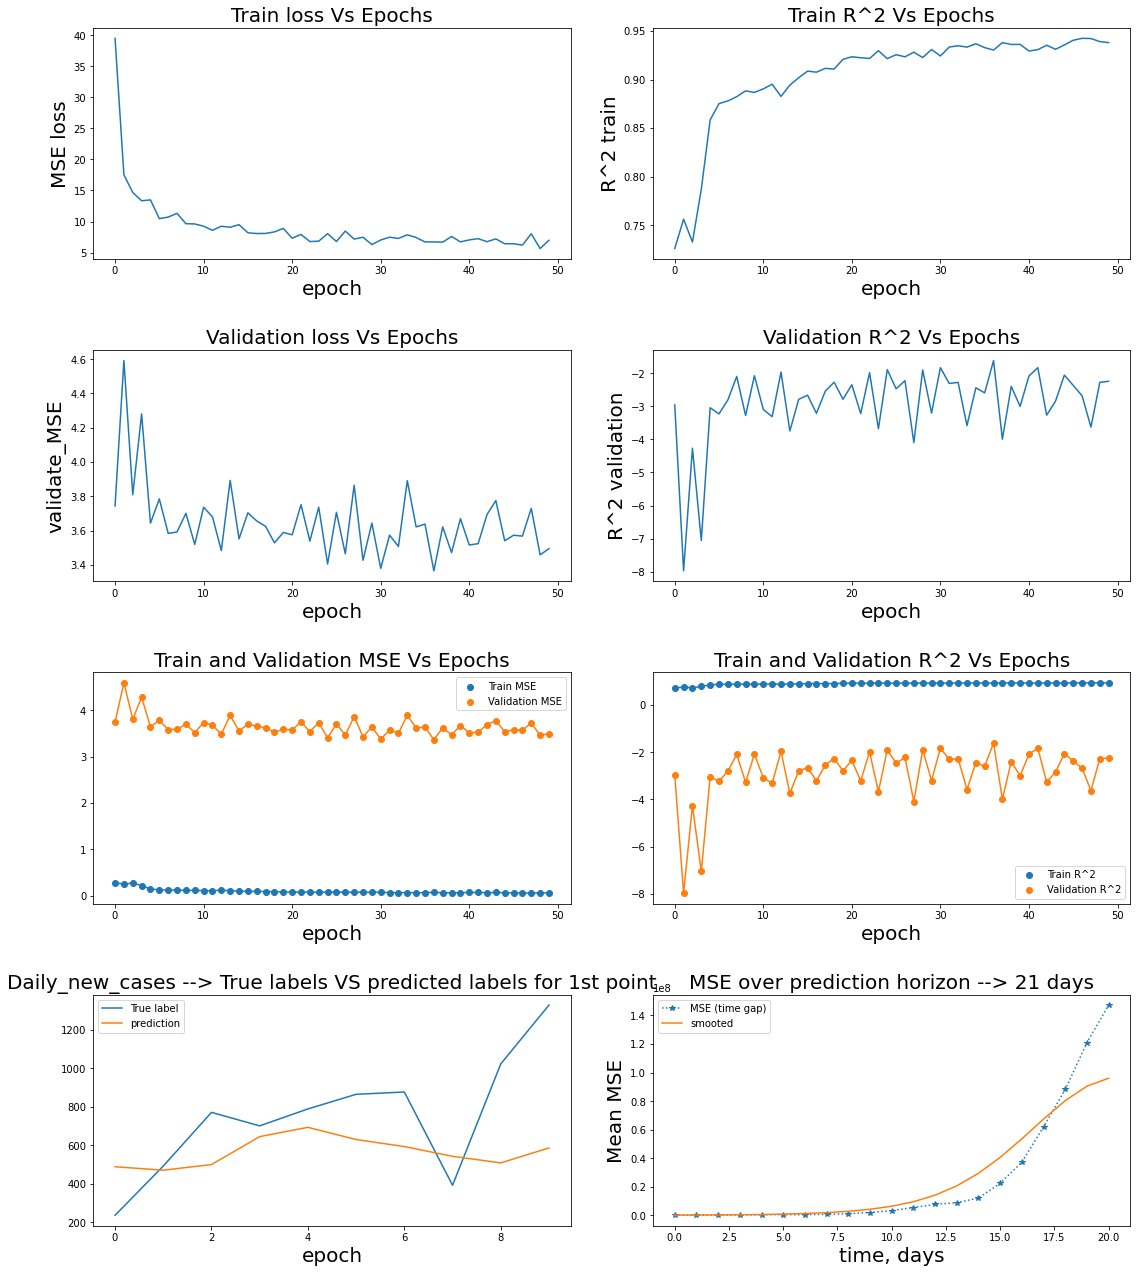

In [98]:
label_to_predict="Daily_new_cases"
y_true_1, y_pred_1 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log, scaler_y = scaler_y, 
                 label_to_predict = label_to_predict)

In [99]:
df_compare_true_to_pred_values_list1, df_mean_compare_true_to_pred_values_1, df_mean_outcomes_dayily_new_cases = show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_1)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_new_cases)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,607.000,498.432
2021-12-12,1.500,236.000,484.140
2021-12-13,2.000,492.000,462.954
2021-12-14,2.500,771.000,498.722
2021-12-15,3.000,701.000,537.406
2021-12-16,3.500,789.000,550.854
2021-12-17,4.000,865.000,529.499
2021-12-18,4.500,877.000,483.067
2021-12-19,5.000,392.000,462.921


-------------------------------------------------------


Week 1            Week 2            Week 3        
                 y_true  y_pred    y_true  y_pred    y_true  y_pred
Daily_new_cases 637.286 508.858 1,107.857 499.999 2,826.000 534.021

In [ ]:
######################################################

#  Predicting <font color = purple > #2 </font>  - <font color = Darkorchbid > Daily_death_cases </font> 

In [100]:
label_to_predict="Daily_death_cases"
history_samples = 14
horizon_samples = 21
hidden_dim = 100
num_LSTM_layers = 1
fully_connected_layers=[300, 250]
drop_out_for_fully_connected = 0.1
batch_norm_for_fully_connected = True
n_epochs = 60
batch_size = 100
lr_optimizer = 0.005

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | Daily_death_cases | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 60 | Loss: 22.2148 | Train MSE: 0.4181 | Train R^2: 0.5886 ||| Validate MSE: 0.2997 | Validation R^2: -60.1721
3 of 60 | Loss: 17.0885 | Train MSE: 0.1737 | Train R^2: 0.8292 ||| Validate MSE: 0.0253 | Validation R^2: -3.8448
5 of 60 | Loss: 14.9688 | Train MSE: 0.1163 | Train R^2: 0.8856 ||| Validate MSE: 0.0167 | Validation R^2: -2.2357
7 of 60 | Loss: 15.1883 | Train MSE: 0.1290 | Train R^2: 0.8731 ||| Validate MSE: 0.0535 | Validation R^2: -9.8254
9 of 60 | Loss: 13.1686 | 

model performance regarding the variable: Daily_death_cases
------------------------------------------------------------------------------


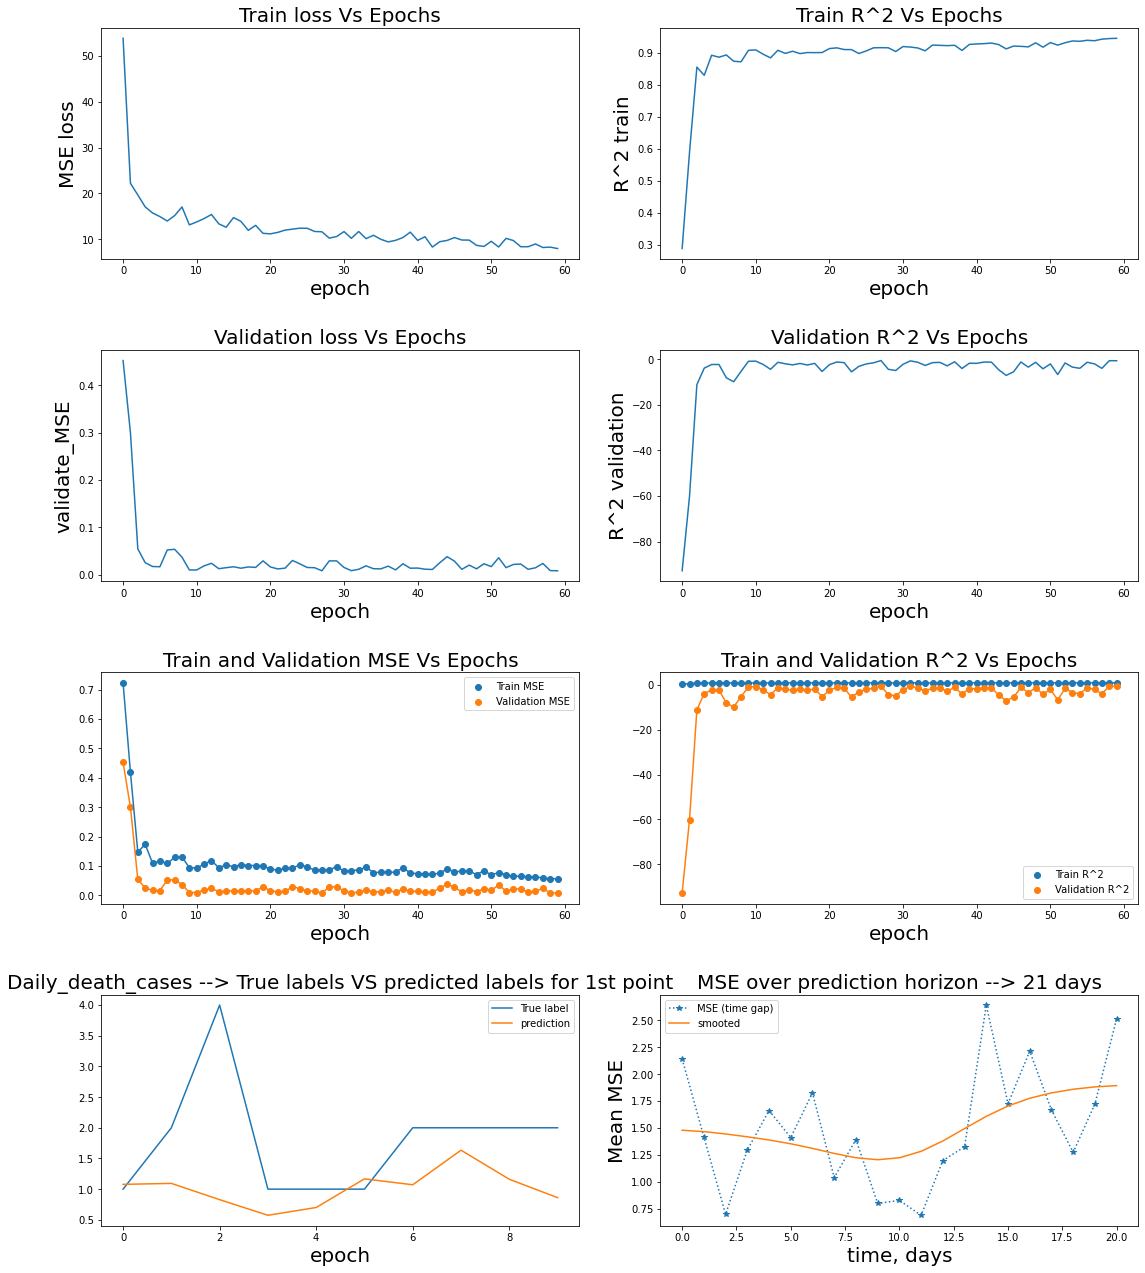

In [101]:
label_to_predict="Daily_death_cases"
y_true_2, y_pred_2 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [102]:
df_compare_true_to_pred_values_list2, df_mean_compare_true_to_pred_values_2, df_mean_outcomes_dayily_deaths = show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_2)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_deaths)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,2.000,2.752
2021-12-12,1.500,1.000,2.078
2021-12-13,2.000,2.000,1.679
2021-12-14,2.500,4.000,1.756
2021-12-15,3.000,1.000,1.335
2021-12-16,3.500,1.000,1.361
2021-12-17,4.000,1.000,1.423
2021-12-18,4.500,2.000,1.333
2021-12-19,5.000,2.000,1.497


-------------------------------------------------------


Week 1        Week 2        Week 3       
                  y_true y_pred y_true y_pred y_true y_pred
Daily_death_cases  1.714  1.769  1.286  1.272  1.143  1.178

#  Predicting <font color = purple > #3 </font>  - <font color = Darkorchbid > positive cases </font> 

In [130]:
label_to_predict="corona_result_positive"
history_samples = 14
horizon_samples = 21
hidden_dim = 170
num_LSTM_layers = 2
fully_connected_layers=[400, 250, 100]
drop_out_for_fully_connected = 0.21
batch_norm_for_fully_connected = True
n_epochs = 65
batch_size = 100
lr_optimizer = 0.006

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | corona_result_positive | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 65 | Loss: 42.2276 | Train MSE: 0.4527 | Train R^2: 0.5613 ||| Validate MSE: 2.3131 | Validation R^2: -26.5474
3 of 65 | Loss: 33.1537 | Train MSE: 0.3290 | Train R^2: 0.6814 ||| Validate MSE: 2.5285 | Validation R^2: -64.0395
5 of 65 | Loss: 27.3386 | Train MSE: 0.2600 | Train R^2: 0.7482 ||| Validate MSE: 2.2870 | Validation R^2: -48.9490
7 of 65 | Loss: 24.9082 | Train MSE: 0.2194 | Train R^2: 0.7876 ||| Validate MSE: 1.9638 | Validation R^2: -7.2499
9 of 65 | Loss: 23.

In [104]:
#59 of 60 | Loss: 4.5901 | Train MSE: 0.0240 | Train R^2: 0.9766 ||| Validate MSE: 0.0040 | Validation R^2: -4.0719

model performance regarding the variable: corona_result_positive
------------------------------------------------------------------------------


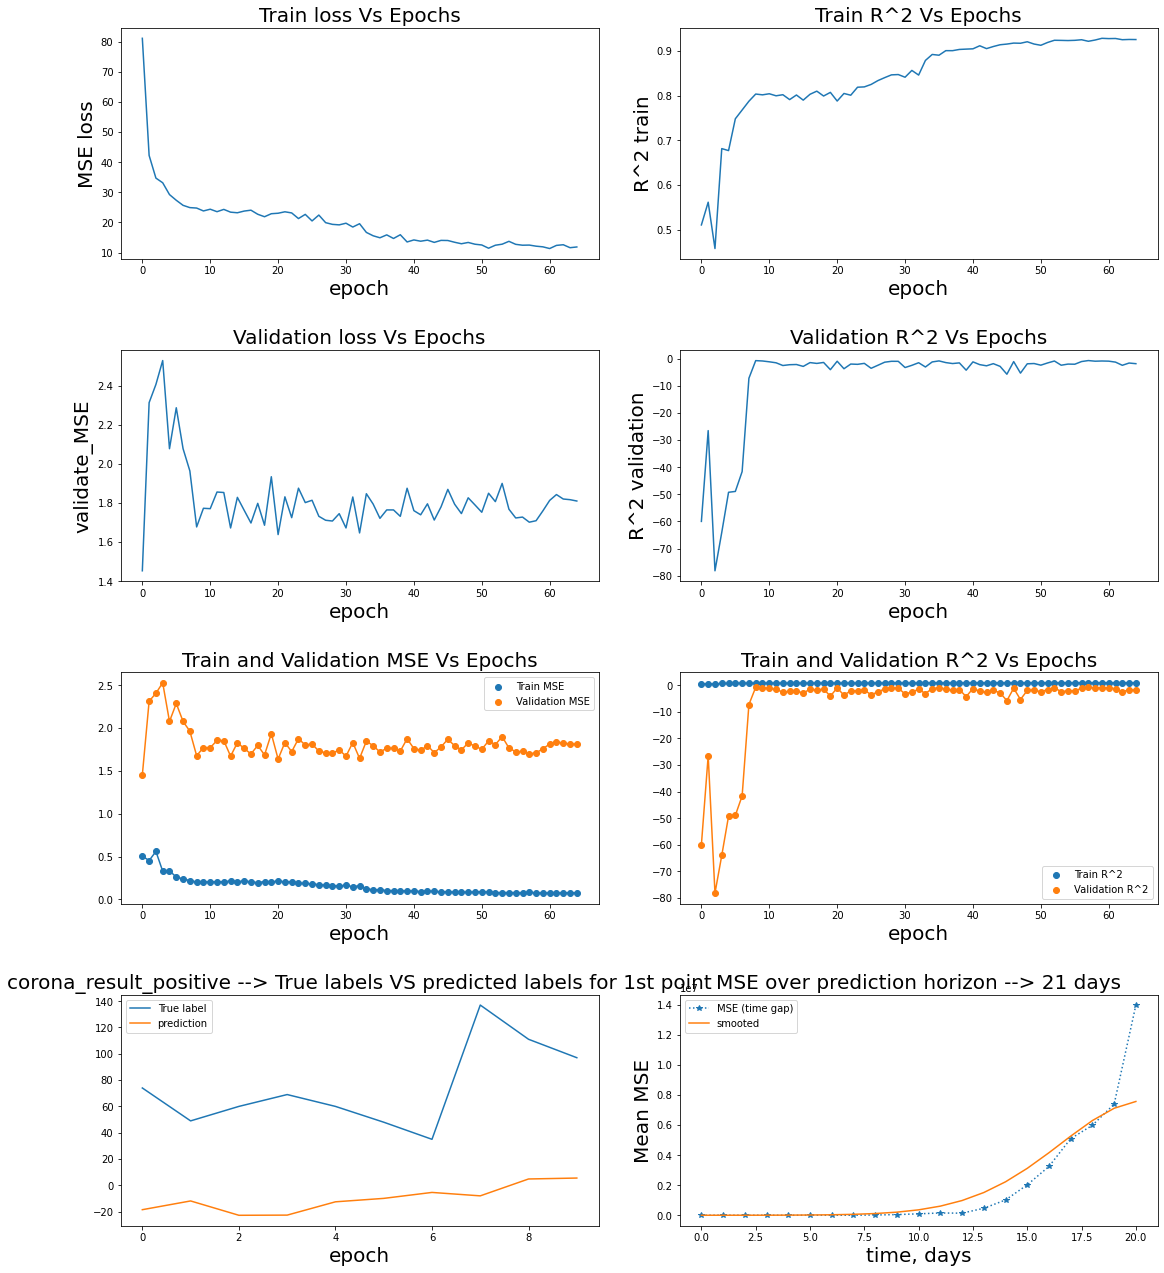

In [131]:
label_to_predict="corona_result_positive"
y_true_3, y_pred_3 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [132]:
df_compare_true_to_pred_values_list3, df_mean_compare_true_to_pred_values_3, df_mean_outcomes_dayily_corona_result_positive = show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_3)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_corona_result_positive)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,11.000,82.847
2021-12-12,1.500,74.000,34.928
2021-12-13,2.000,49.000,37.459
2021-12-14,2.500,60.000,27.798
2021-12-15,3.000,69.000,45.961
2021-12-16,3.500,60.000,66.617
2021-12-17,4.000,48.000,75.837
2021-12-18,4.500,35.000,79.592
2021-12-19,5.000,137.000,78.124


-------------------------------------------------------


Week 1         Week 2         Week 3       
                       y_true y_pred  y_true y_pred  y_true y_pred
corona_result_positive 53.000 53.064 103.000 77.282 423.571 77.850

#  Predicting <font color = purple > #4 </font>  - <font color = Darkorchbid > number_of_tests </font> 


In [107]:
label_to_predict="number_of_tests"
history_samples = 14
horizon_samples = 21
hidden_dim = 100
num_LSTM_layers = 1
fully_connected_layers=[300, 250]
drop_out_for_fully_connected = 0.1
batch_norm_for_fully_connected = True
n_epochs = 60
batch_size = 100
lr_optimizer = 0.005

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | number_of_tests | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 60 | Loss: 36.9286 | Train MSE: 0.5703 | Train R^2: 0.4250 ||| Validate MSE: 0.4874 | Validation R^2: -8.8041
3 of 60 | Loss: 26.0419 | Train MSE: 0.3515 | Train R^2: 0.6456 ||| Validate MSE: 0.3798 | Validation R^2: -4.0127
5 of 60 | Loss: 20.2436 | Train MSE: 0.2402 | Train R^2: 0.7578 ||| Validate MSE: 0.4182 | Validation R^2: -4.7449
7 of 60 | Loss: 16.3621 | Train MSE: 0.1193 | Train R^2: 0.8797 ||| Validate MSE: 0.4067 | Validation R^2: -1.1006
9 of 60 | Loss: 13.8637 | Tra

model performance regarding the variable: number_of_tests
------------------------------------------------------------------------------


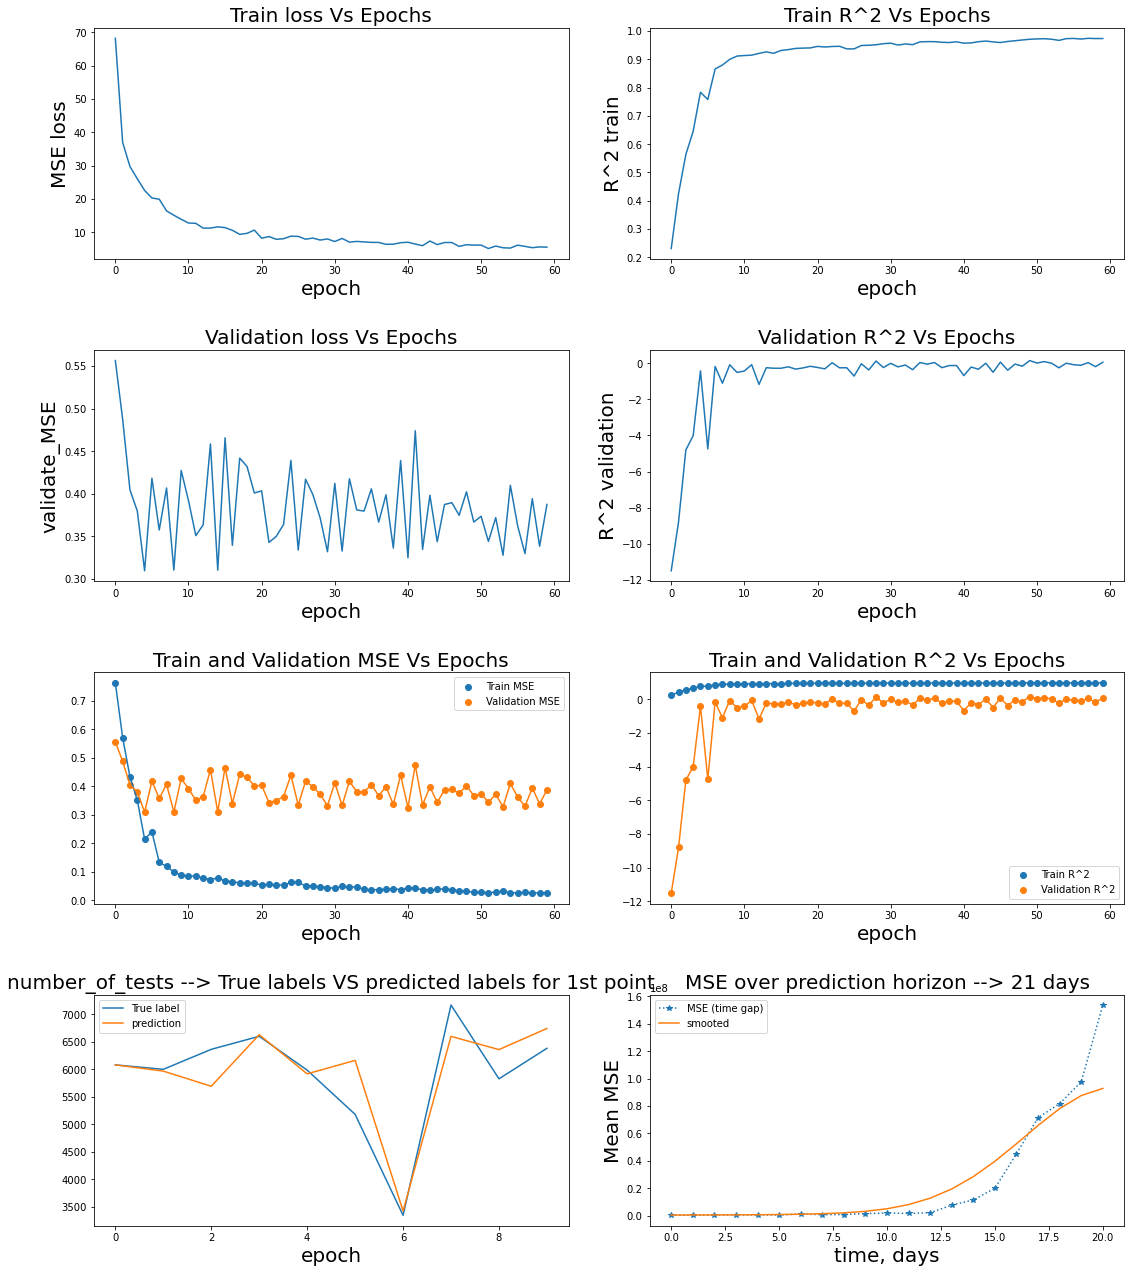

In [108]:
label_to_predict="number_of_tests"
y_true_4, y_pred_4 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [109]:
df_compare_true_to_pred_values_list4, df_mean_compare_true_to_pred_values_4, df_mean_outcomes_dayily_number_of_tests = show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_4)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_number_of_tests)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,"2,696.000","3,021.645"
2021-12-12,1.500,"6,082.000","6,290.484"
2021-12-13,2.000,"6,001.000","6,080.342"
2021-12-14,2.500,"6,365.000","6,340.950"
2021-12-15,3.000,"6,603.000","6,005.763"
2021-12-16,3.500,"5,986.000","5,986.988"
2021-12-17,4.000,"5,180.000","5,644.644"
2021-12-18,4.500,"3,341.000","3,369.986"
2021-12-19,5.000,"7,172.000","6,441.810"


-------------------------------------------------------


Week 1              Week 2              Week 3          
                   y_true    y_pred    y_true    y_pred    y_true    y_pred
number_of_tests 5,559.000 5,624.402 5,749.429 5,986.954 8,064.429 6,543.665

#  Predicting <font color = purple > #5 </font>  - <font color = Darkorchbid > hospitalized </font> 

In [110]:
label_to_predict="hospitalized"
history_samples = 14
horizon_samples = 21
hidden_dim = 100
num_LSTM_layers = 1
fully_connected_layers=[300, 250]
drop_out_for_fully_connected = 0.1
batch_norm_for_fully_connected = True
n_epochs = 60
batch_size = 100
lr_optimizer = 0.005

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | hospitalized | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 60 | Loss: 14.0759 | Train MSE: 0.3298 | Train R^2: 0.6756 ||| Validate MSE: 0.2406 | Validation R^2: -717.1756
3 of 60 | Loss: 8.1695 | Train MSE: 0.0344 | Train R^2: 0.9662 ||| Validate MSE: 0.0752 | Validation R^2: -14.7913
5 of 60 | Loss: 7.1168 | Train MSE: 0.0321 | Train R^2: 0.9686 ||| Validate MSE: 0.0443 | Validation R^2: -19.0829
7 of 60 | Loss: 6.2466 | Train MSE: 0.0180 | Train R^2: 0.9823 ||| Validate MSE: 0.0653 | Validation R^2: -8.5533
9 of 60 | Loss: 4.7285 | Train 

model performance regarding the variable: hospitalized
------------------------------------------------------------------------------


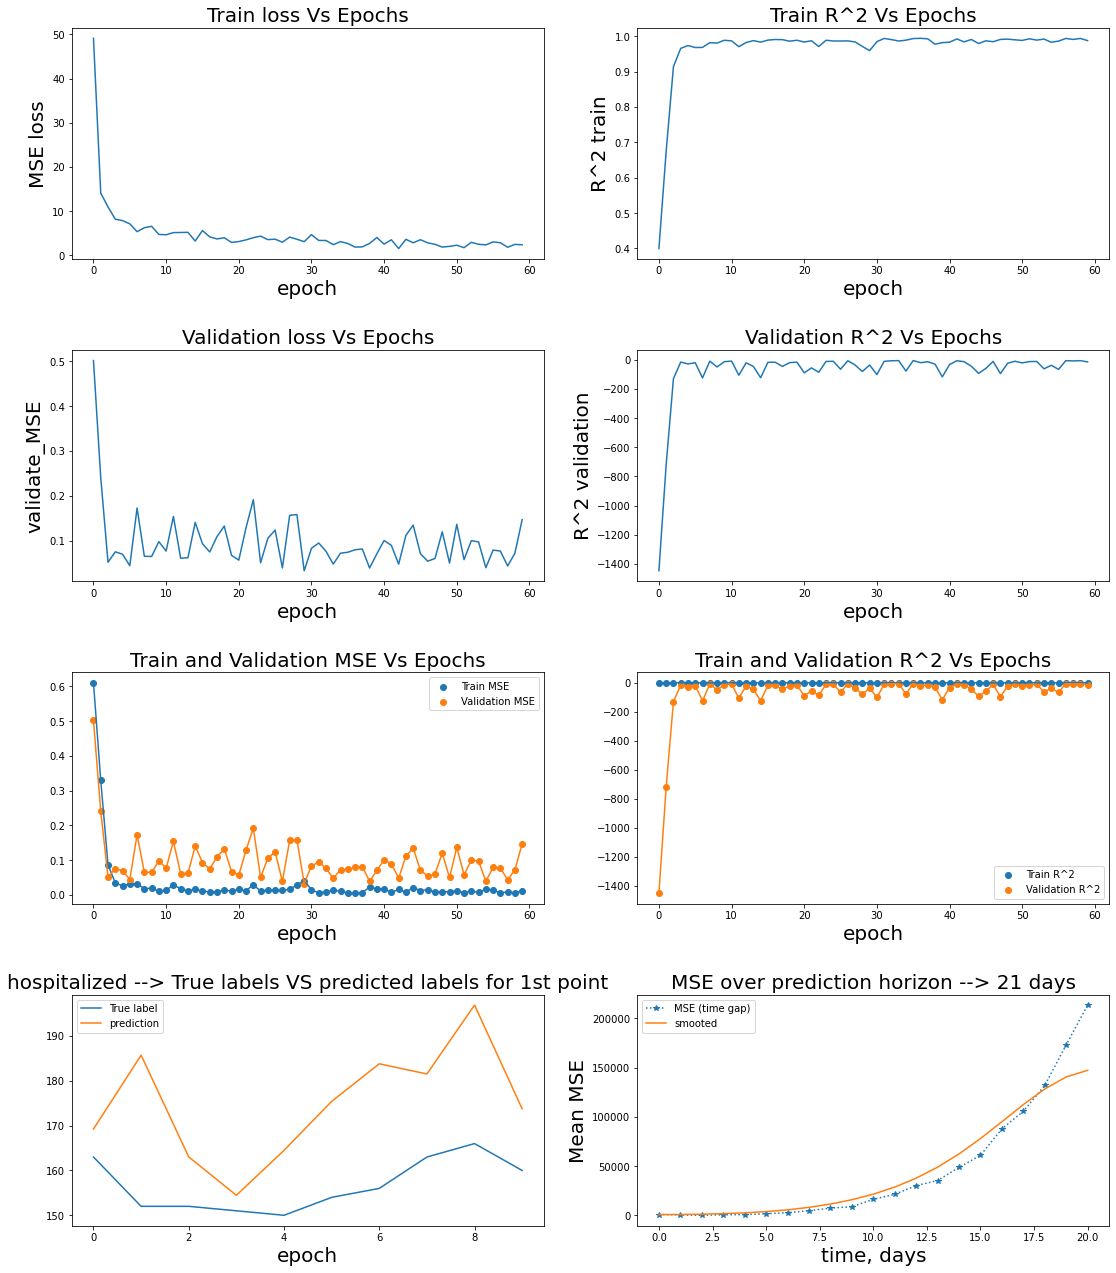

In [111]:
label_to_predict="hospitalized"
y_true_5, y_pred_5 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [112]:
df_compare_true_to_pred_values_list5, df_mean_compare_true_to_pred_values_5, df_mean_outcomes_dayily_hospitalized= show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_5)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_hospitalized)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,160.000,177.617
2021-12-12,1.500,163.000,182.370
2021-12-13,2.000,152.000,169.863
2021-12-14,2.500,152.000,155.774
2021-12-15,3.000,151.000,149.653
2021-12-16,3.500,150.000,145.869
2021-12-17,4.000,154.000,143.719
2021-12-18,4.500,156.000,140.174
2021-12-19,5.000,163.000,138.018


-------------------------------------------------------


Week 1          Week 2          Week 3       
              y_true  y_pred  y_true  y_pred  y_true y_pred
hospitalized 154.571 160.695 165.714 119.300 224.714 56.280

#  Predicting <font color = purple > #6 </font>  - <font color = Darkorchbid > light_sick </font> 

In [113]:
label_to_predict="light_sick"
history_samples = 14
horizon_samples = 21
hidden_dim = 100
num_LSTM_layers = 1
fully_connected_layers=[300, 250]
drop_out_for_fully_connected = 0.1
batch_norm_for_fully_connected = True
n_epochs = 60
batch_size = 100
lr_optimizer = 0.005

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | light_sick | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 60 | Loss: 16.2099 | Train MSE: 0.3723 | Train R^2: 0.6327 ||| Validate MSE: 0.3326 | Validation R^2: -115.1105
3 of 60 | Loss: 8.8237 | Train MSE: 0.0584 | Train R^2: 0.9424 ||| Validate MSE: 0.2905 | Validation R^2: -4.3663
5 of 60 | Loss: 7.6540 | Train MSE: 0.0316 | Train R^2: 0.9688 ||| Validate MSE: 0.4107 | Validation R^2: -5.5051
7 of 60 | Loss: 6.9663 | Train MSE: 0.0252 | Train R^2: 0.9751 ||| Validate MSE: 0.5437 | Validation R^2: -21.6439
9 of 60 | Loss: 5.5766 | Train MSE

model performance regarding the variable: light_sick
------------------------------------------------------------------------------


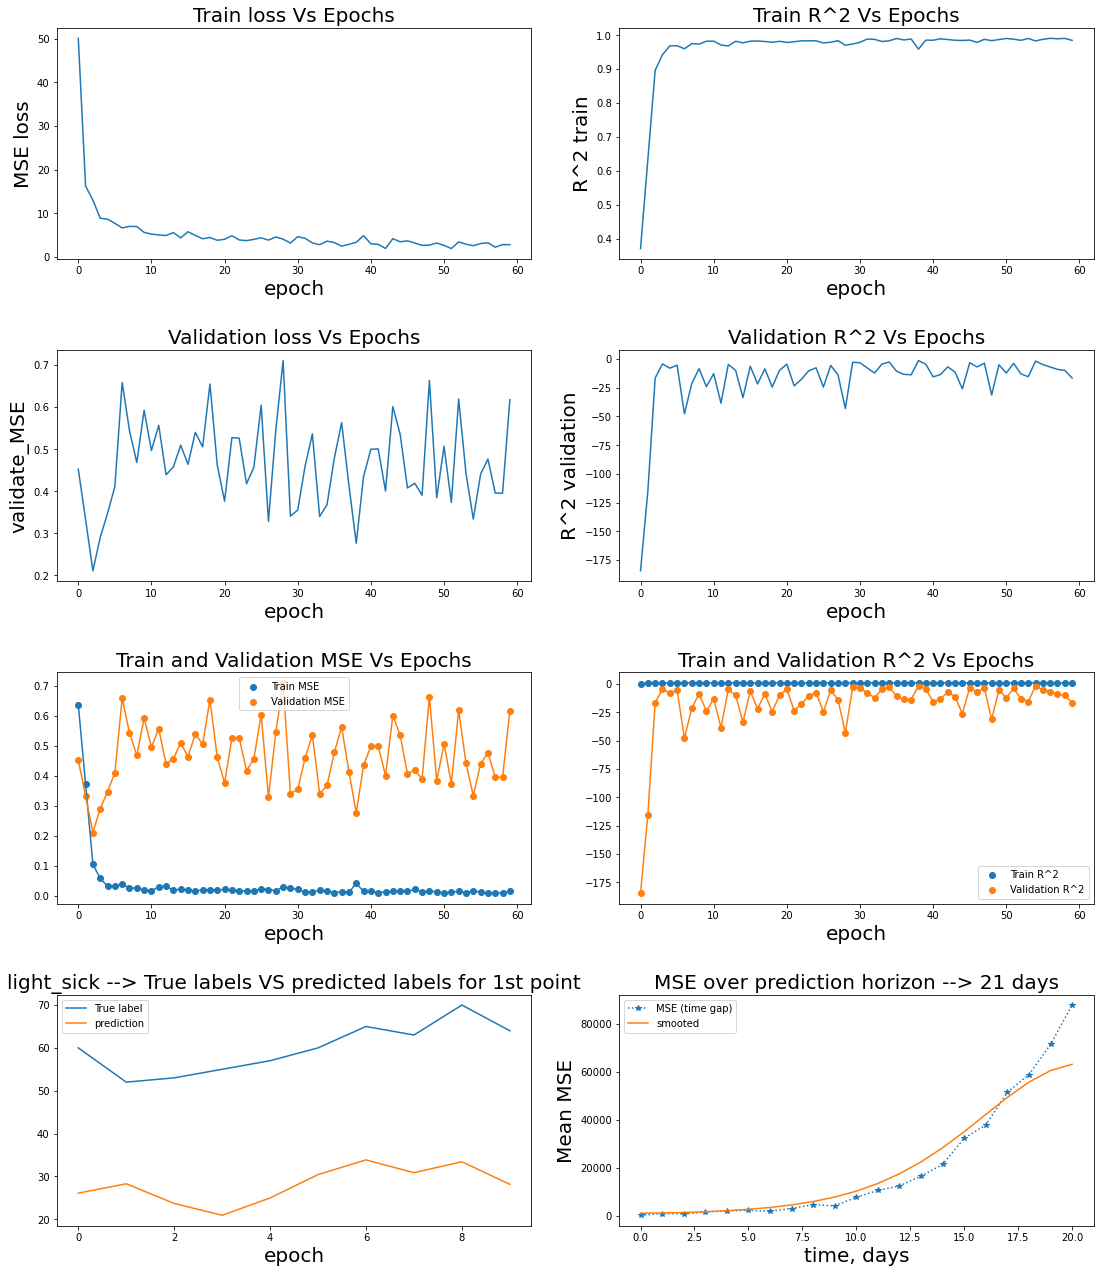

In [114]:
label_to_predict="light_sick"
y_true_6, y_pred_6 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [115]:
df_compare_true_to_pred_values_list6, df_mean_compare_true_to_pred_values_6, df_mean_outcomes_dayily_light_sick= show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_6)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_light_sick)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,56.000,40.030
2021-12-12,1.500,60.000,34.772
2021-12-13,2.000,52.000,32.325
2021-12-14,2.500,53.000,28.136
2021-12-15,3.000,55.000,26.272
2021-12-16,3.500,57.000,25.558
2021-12-17,4.000,60.000,26.762
2021-12-18,4.500,65.000,26.564
2021-12-19,5.000,63.000,25.720


-------------------------------------------------------


Week 1        Week 2         Week 3       
           y_true y_pred y_true y_pred  y_true y_pred
light_sick 56.143 30.551 69.286 21.192 116.571  5.582

#  Predicting <font color = purple > #7 </font>  - <font color = Darkorchbid > medium_sick </font> 

In [116]:
label_to_predict="medium_sick"
history_samples = 14
horizon_samples = 21
hidden_dim = 100
num_LSTM_layers = 1
fully_connected_layers=[300, 250]
drop_out_for_fully_connected = 0.1
batch_norm_for_fully_connected = True
n_epochs = 60
batch_size = 100
lr_optimizer = 0.005

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | medium_sick | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 60 | Loss: 17.7004 | Train MSE: 0.3406 | Train R^2: 0.6567 ||| Validate MSE: 0.4389 | Validation R^2: -506.9599
3 of 60 | Loss: 10.2301 | Train MSE: 0.0676 | Train R^2: 0.9320 ||| Validate MSE: 0.0352 | Validation R^2: -35.4926
5 of 60 | Loss: 8.1830 | Train MSE: 0.0334 | Train R^2: 0.9663 ||| Validate MSE: 0.0178 | Validation R^2: -12.9502
7 of 60 | Loss: 7.8930 | Train MSE: 0.0329 | Train R^2: 0.9668 ||| Validate MSE: 0.0124 | Validation R^2: -6.4765
9 of 60 | Loss: 5.9204 | Train 

model performance regarding the variable: medium_sick
------------------------------------------------------------------------------


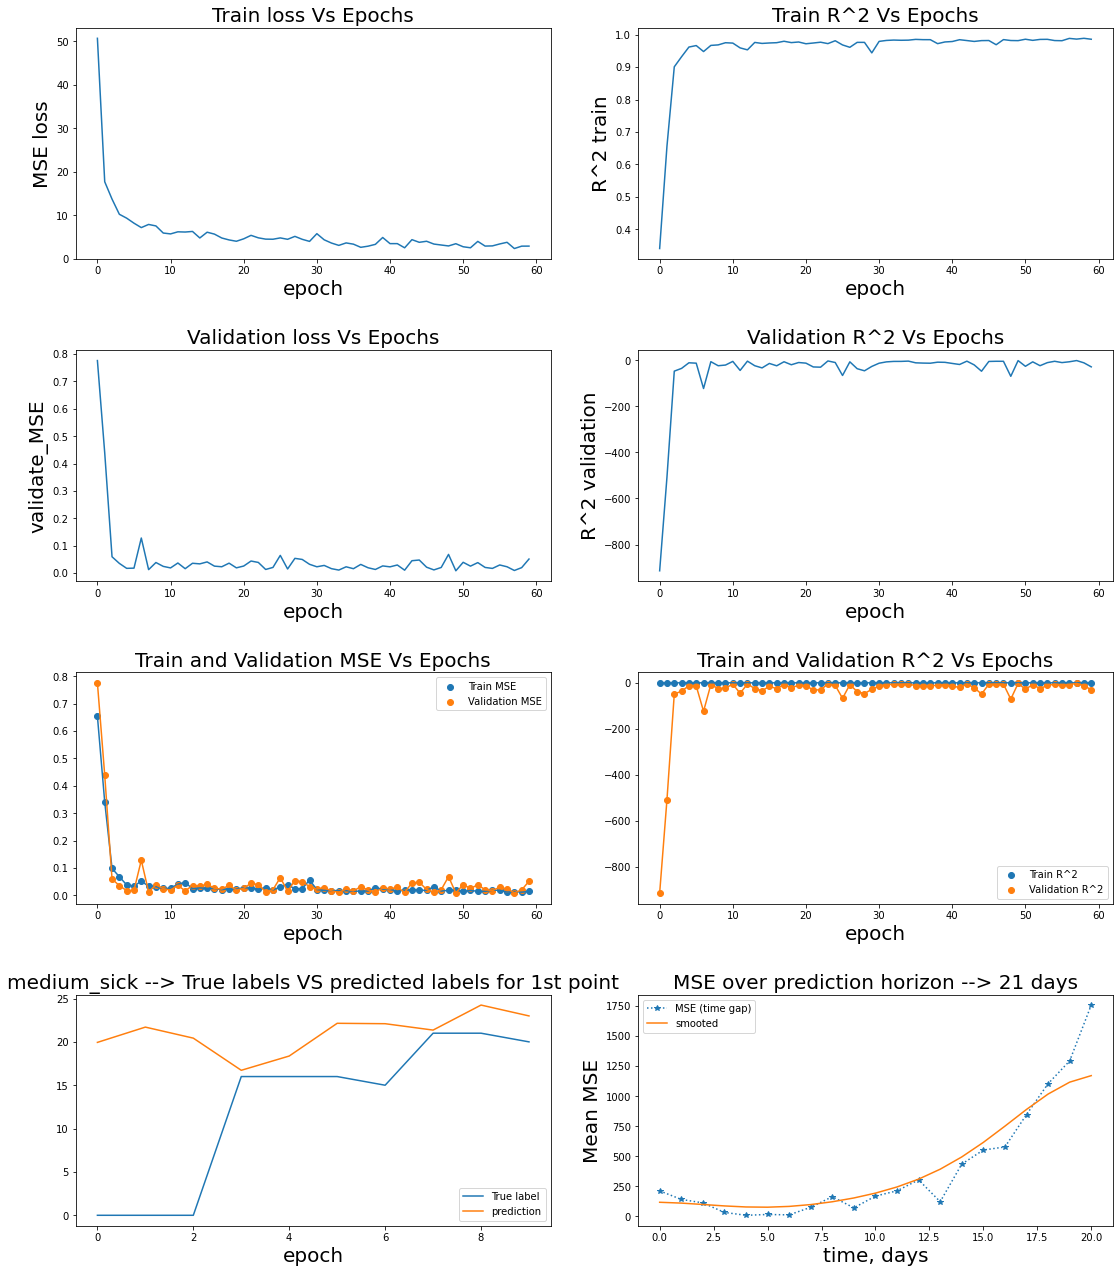

In [117]:
label_to_predict="medium_sick"
y_true_7, y_pred_7 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [118]:
df_compare_true_to_pred_values_list7, df_mean_compare_true_to_pred_values_7, df_mean_outcomes_dayily_medium_sick= show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_7)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_medium_sick)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,0.000,21.301
2021-12-12,1.500,0.000,21.756
2021-12-13,2.000,0.000,21.638
2021-12-14,2.500,0.000,18.878
2021-12-15,3.000,16.000,18.035
2021-12-16,3.500,16.000,18.049
2021-12-17,4.000,16.000,17.985
2021-12-18,4.500,15.000,17.208
2021-12-19,5.000,21.000,16.706


-------------------------------------------------------


Week 1        Week 2        Week 3       
            y_true y_pred y_true y_pred y_true y_pred
medium_sick  6.857 19.663 19.286 14.498 21.571  4.658

#  Predicting <font color = purple > #8 </font>  - <font color = Darkorchbid > hard_sick </font> 

In [119]:
label_to_predict="hard_sick"
history_samples = 14
horizon_samples = 21
hidden_dim = 100
num_LSTM_layers = 1
fully_connected_layers=[300, 250]
drop_out_for_fully_connected = 0.1
batch_norm_for_fully_connected = True
n_epochs = 60
batch_size = 100
lr_optimizer = 0.005

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | hard_sick | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 60 | Loss: 12.8085 | Train MSE: 0.2900 | Train R^2: 0.7109 ||| Validate MSE: 0.2217 | Validation R^2: -968.8217
3 of 60 | Loss: 7.6884 | Train MSE: 0.0348 | Train R^2: 0.9653 ||| Validate MSE: 0.0093 | Validation R^2: -62.9665
5 of 60 | Loss: 7.0109 | Train MSE: 0.0225 | Train R^2: 0.9775 ||| Validate MSE: 0.0169 | Validation R^2: -63.2326
7 of 60 | Loss: 6.2237 | Train MSE: 0.0263 | Train R^2: 0.9738 ||| Validate MSE: 0.0083 | Validation R^2: -34.3877
9 of 60 | Loss: 4.9589 | Train MS

model performance regarding the variable: hard_sick
------------------------------------------------------------------------------


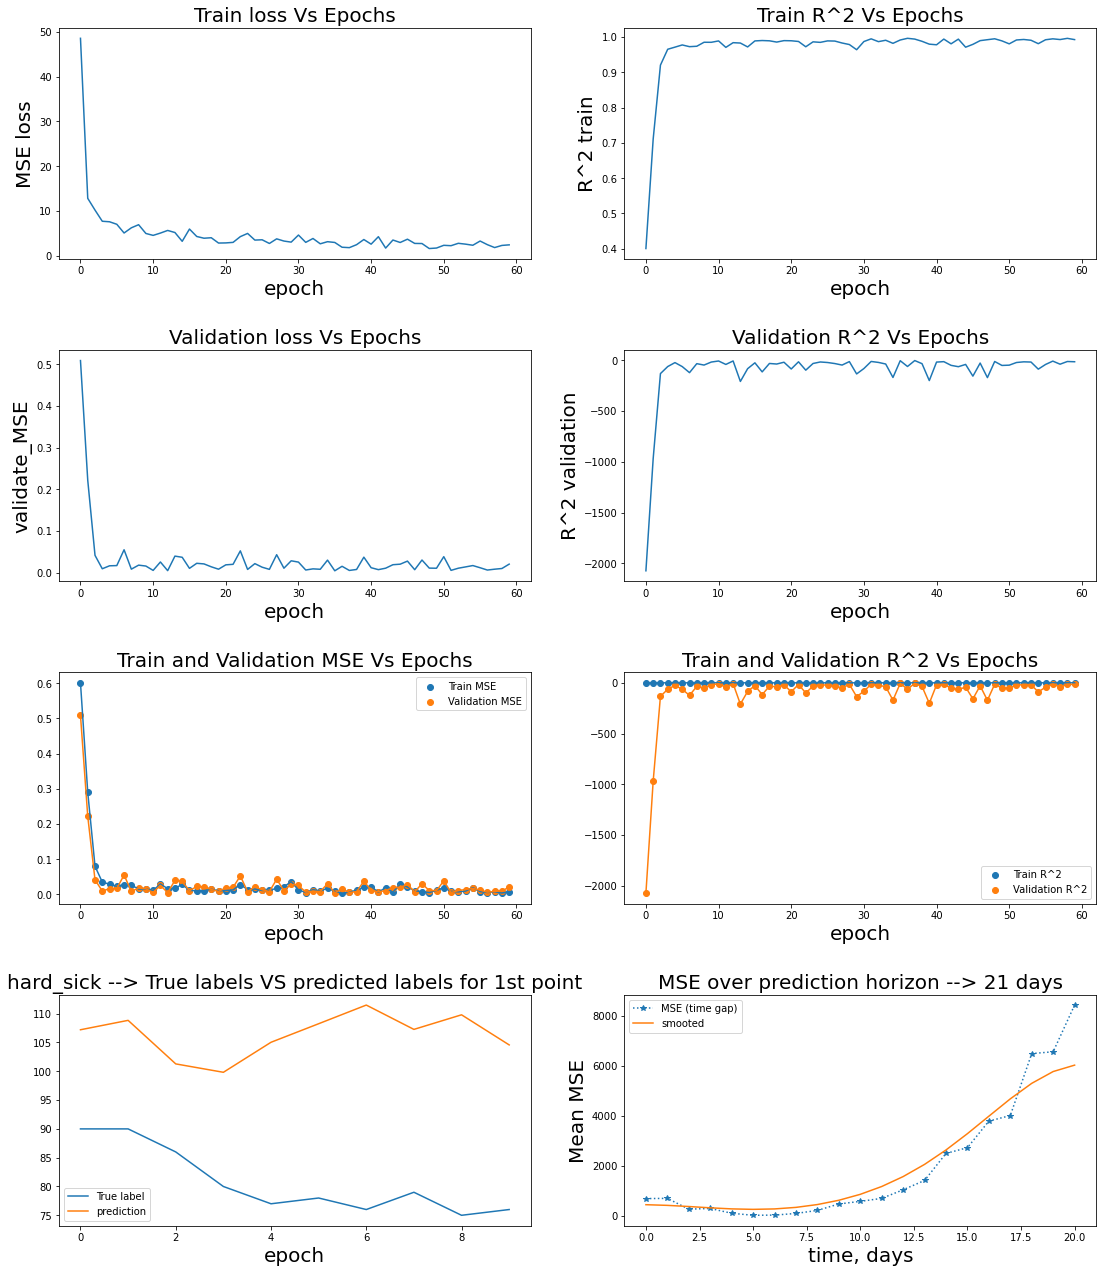

In [120]:
label_to_predict="hard_sick"
y_true_8, y_pred_8 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [121]:
df_compare_true_to_pred_values_list8, df_mean_compare_true_to_pred_values_8, df_mean_outcomes_dayily_hard_sick= show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_8)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_hard_sick)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,95.000,109.385
2021-12-12,1.500,90.000,109.097
2021-12-13,2.000,90.000,102.382
2021-12-14,2.500,86.000,98.773
2021-12-15,3.000,80.000,96.095
2021-12-16,3.500,77.000,93.838
2021-12-17,4.000,78.000,91.725
2021-12-18,4.500,76.000,89.037
2021-12-19,5.000,79.000,86.781


-------------------------------------------------------


Week 1         Week 2        Week 3       
          y_true  y_pred y_true y_pred y_true y_pred
hard_sick 85.143 100.185 77.143 78.158 86.571 51.601

#  Predicting <font color = purple > #9 </font>  - <font color = Darkorchbid > ventilated </font> 

In [122]:
label_to_predict="ventilated"
history_samples = 14
horizon_samples = 21
hidden_dim = 100
num_LSTM_layers = 1
fully_connected_layers=[300, 250]
drop_out_for_fully_connected = 0.1
batch_norm_for_fully_connected = True
n_epochs = 60
batch_size = 100
lr_optimizer = 0.005

lstm_model_new, progress_log, all_data, train_set, test_set, time_labels_indexes_test, scaler, scaler_y = time_series_all_model(
                          df = df, history_samples = history_samples, horizon_samples = horizon_samples,
                          label_to_predict=label_to_predict,name_of_date_col = "date", train_portion = 0.93,
                          scaler = StandardScaler(), hidden_dim = hidden_dim, num_LSTM_layers = num_LSTM_layers,
                          fully_connected_layers=fully_connected_layers,
                          drop_out_for_fully_connected = drop_out_for_fully_connected,
                          batch_norm_for_fully_connected = batch_norm_for_fully_connected,
                          n_epochs = n_epochs, batch_size = batch_size, criterion = torch.nn.MSELoss(),
                          lr_optimizer = lr_optimizer,
                          device = device, random_state = 1998)


part A - defining history_smaples, horizon_samples and label to predict
Using data of | 14 | past days in order to predict the value of: | ventilated | for the following | 21 | future days

Part B - Split data into train and test sets
Data set has: 636 rows | history size: 14 | Prediction window size: 21 
Train set size: 591: from 0 to: 590
Test set size: 10: from 626 to: 635
sample size: x: torch.Size([14, 58]), y: torch.Size([21])

Part C - Scaling the data with standard scaler

Part D - LSTM Model
1 of 60 | Loss: 12.3166 | Train MSE: 0.2904 | Train R^2: 0.7090 ||| Validate MSE: 0.4318 | Validation R^2: -1601.9342
3 of 60 | Loss: 7.7261 | Train MSE: 0.0671 | Train R^2: 0.9328 ||| Validate MSE: 0.0848 | Validation R^2: -297.8441
5 of 60 | Loss: 7.6813 | Train MSE: 0.0343 | Train R^2: 0.9656 ||| Validate MSE: 0.0068 | Validation R^2: -17.4759
7 of 60 | Loss: 8.0481 | Train MSE: 0.0511 | Train R^2: 0.9488 ||| Validate MSE: 0.2361 | Validation R^2: -750.0825
9 of 60 | Loss: 5.5827 | Trai

model performance regarding the variable: ventilated
------------------------------------------------------------------------------


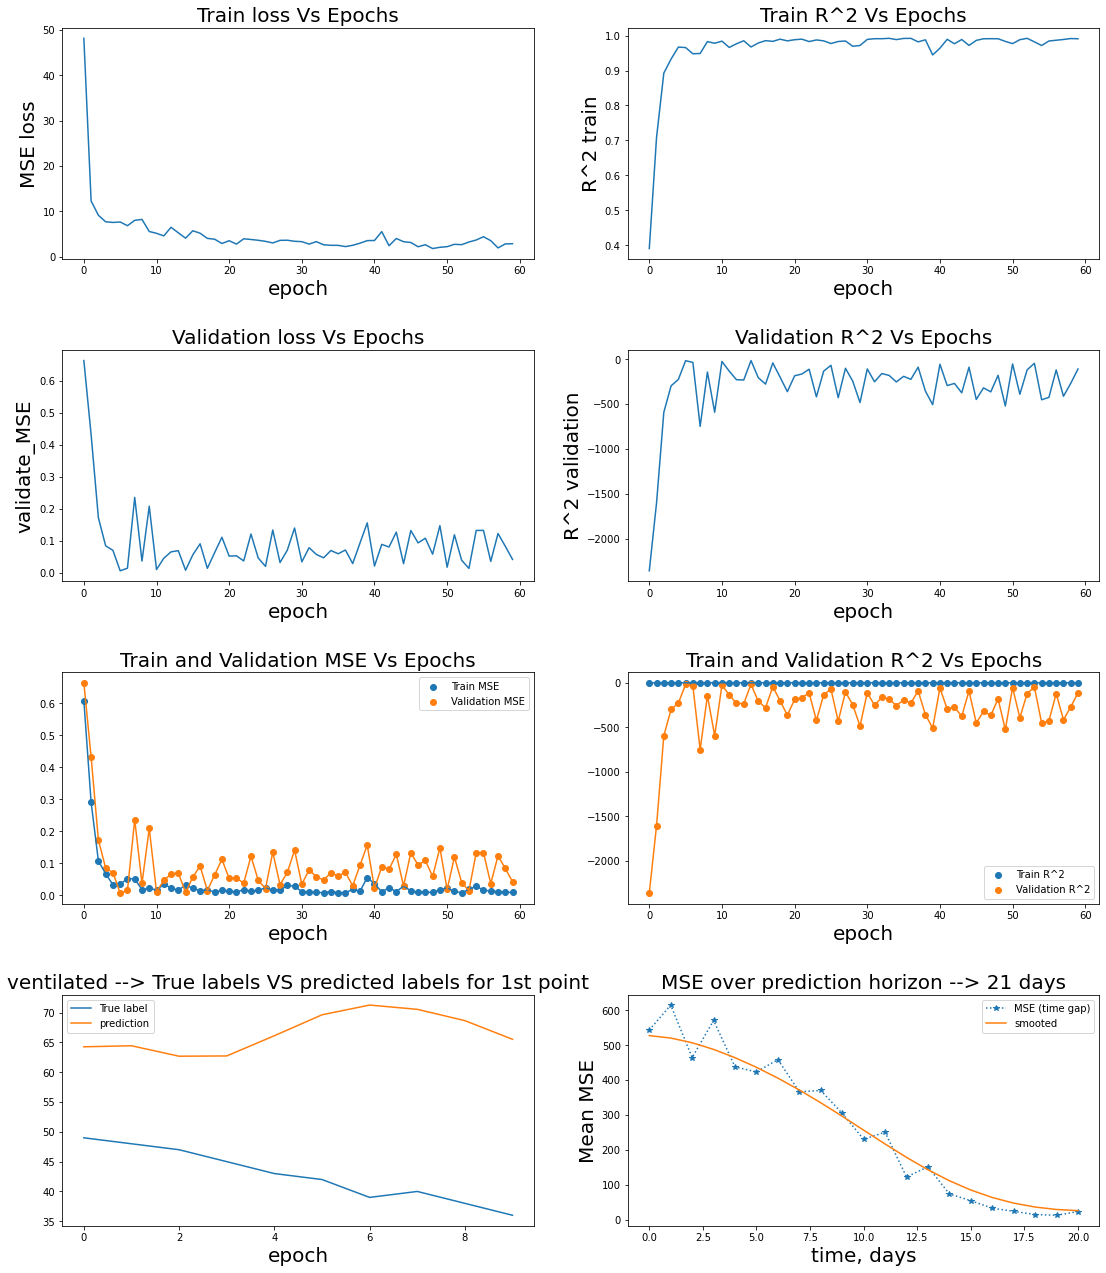

In [123]:
label_to_predict="ventilated"
y_true_9, y_pred_9 = plots_time_series(model = lstm_model_new,
                  test_set = test_set,
                  progress_log = progress_log,
                  scaler_y = scaler_y,
                  label_to_predict = label_to_predict)


In [124]:
df_compare_true_to_pred_values_list9, df_mean_compare_true_to_pred_values_9, df_mean_outcomes_dayily_ventilated = show_prediction_vs_true_labels(
                                                                      model = lstm_model_new,
                                                                      test_set = test_set,
                                                                      scaler_y = scaler_y,
                                                                      time_labels_indexes_test = time_labels_indexes_test,
                                                                      label_to_predict = label_to_predict)
#### lets see some predictions
#display(df_compare_true_to_pred_values_list1[0])
print("displaying the mean value - after grouping by the date column")
display(df_mean_compare_true_to_pred_values_9)
print("-------------------------------------------------------")
display(df_mean_outcomes_dayily_ventilated)

displaying the mean value - after grouping by the date column


,day,y_true,y_pred
date,,,
2021-12-11,1.000,51.000,64.694
2021-12-12,1.500,49.000,64.594
2021-12-13,2.000,48.000,62.125
2021-12-14,2.500,47.000,61.400
2021-12-15,3.000,45.000,60.749
2021-12-16,3.500,43.000,60.751
2021-12-17,4.000,42.000,61.150
2021-12-18,4.500,39.000,60.935
2021-12-19,5.000,40.000,60.520


-------------------------------------------------------


Week 1        Week 2        Week 3       
           y_true y_pred y_true y_pred y_true y_pred
ventilated 46.429 62.209 37.429 57.782 36.143 47.287

# Conclusions for Question 2 - Part a:

We can see that overall, the MSE **increases** as we look further into the future, except when predicting ventilated. This can be seen in the first 8  MSE plots, that the mean MSE increases as we go further into the future.
This is reasenable as we try to predict more into the future, our data is'nt sufficint for catching future possible changes. This phenomena is also generally known in the day-to-day life.

**Note:** in the previous sections (predicting the 9 possible labels), we demonstrate a few out of sample predictions and estimate accuracy of our algorithms on test set (there is a table for each label that displays the date, the true value of the label and the value of the prediction)

For each of the cases above predict the future daily number of cases. Demonstrate few out
of sample predictions and estimate accuracy of your algorithms on test set. How accuracy
drops as you would look further into the future?

# Conclusions for Question 2 - Part B: Using a table to summarize these findings

In [95]:
pd.options.display.float_format = '{:,.3f}'.format #this will make the final table to show only 3 decimal points

df_mean_outcomes_all = pd.concat([df_mean_outcomes_dayily_deaths,
                                  df_mean_outcomes_dayily_new_cases,
                                  df_mean_outcomes_dayily_corona_result_positive,
                                 df_mean_outcomes_dayily_number_of_tests,
                                  df_mean_outcomes_dayily_hospitalized,
                                  df_mean_outcomes_dayily_light_sick,
                                  df_mean_outcomes_dayily_medium_sick,
                                  df_mean_outcomes_dayily_hard_sick,
                                  df_mean_outcomes_dayily_ventilated
                                 ])

########################## adding mean_daily_error column
relative_error_week_1 = abs((df_mean_outcomes_all["Week 1"]["y_true"] - df_mean_outcomes_all["Week 1"]["y_pred"]) /  df_mean_outcomes_all["Week 1"]["y_true"])
relative_error_week_2 = abs((df_mean_outcomes_all["Week 2"]["y_true"] - df_mean_outcomes_all["Week 2"]["y_pred"]) /  df_mean_outcomes_all["Week 2"]["y_true"])
relative_error_week_3 = abs((df_mean_outcomes_all["Week 3"]["y_true"] - df_mean_outcomes_all["Week 3"]["y_pred"]) /  df_mean_outcomes_all["Week 3"]["y_true"])
mean_daily_error = (relative_error_week_1+relative_error_week_2+relative_error_week_3)/3 *100

df_mean_outcomes_all["mean_daily_error%"] = mean_daily_error
################################################
# adding dates to the weeks columns
dates_index = df_mean_compare_true_to_pred_values_1.index.strftime('%d.%m')
print_date_week1 = "Week 1 - " + str(dates_index[0]) + " till " + str(dates_index[7])
print_date_week2 = "Week 2 - " + str(dates_index[8]) + " till " + str(dates_index[15])
print_date_week3 = "Week 3 - " + str(dates_index[16]) + " till " + str(dates_index[23])

df_mean_outcomes_all.rename(columns={"Week 1":print_date_week1,
                                     "Week 2":print_date_week2,
                                     "Week 3":print_date_week3}, inplace = True)

display(df_mean_outcomes_all)

Week 1 - 06.12 till 13.12            \
                                          y_true    y_pred   
Daily_death_cases                          2.286    -0.391   
Daily_new_cases                          613.429   490.268   
corona_result_positive                    55.857    50.002   
number_of_tests                        5,007.429 6,079.156   
hospitalized                             158.286   183.186   
light_sick                                51.857    52.950   
medium_sick                                0.000    22.958   
hard_sick                                 95.714   137.319   
ventilated                                54.286    69.728   

                       Week 2 - 14.12 till 21.12            \
                                          y_true    y_pred   
Daily_death_cases                          1.857    -0.022   
Daily_new_cases                          774.000   399.990   
corona_result_positive                    67.571     0.276   
number_of_tests                        5,782.143 5,796.019   
hospitalized                             156.000   173.164   
light_sick                                60.429    46.414   
medium_sick                               15.000    19.462   
hard_sick                                 78.714   119.709   
ventilated                                42.000    51.370   

                       Week 3 - 22.12 till 29.12           mean_daily_error%  
                                          y_true    y_pred                    
Daily_death_cases                          0.857     0.463            88.098  
Daily_new_cases                        1,644.143   385.931            48.309  
corona_result_positive                    50.143    -6.075            74.063  
number_of_tests                        6,500.000 5,798.851            10.810  
hospitalized                             188.714   162.959            13.460  
light_sick                                87.000    39.294            26.711  
medium_sick                               20.429    13.640               inf  
hard_sick                                 81.286   107.743            42.699  
ventilated                                36.000    43.678            24.028

In [ ]:
###################################################################################################

### Conclusions: As you saw, we predicted 9 variables, where in 8 out of the 9 the MSE rises as we predict further in the future, which makes sense as it is harder to know what will happen in the far future than in the near future. 

### Moreover, we would expect that when predicting sickness, it should be "easier" to predict severe cases than predicting light cases as we have more data that explains the predicted variable. Yet, we see that the mean daily error does not follow a certain pattern as we "move" in the chain of sickness (positive -> light sick -> medium sick -> hard sick -> etc.. ). Moreover, the best predicted measurement is the _number of tests_ which only has an aprox 11% of error. 
